In [1]:
# Importing libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from PIL import Image
import functions
from GP_action import GP_action
import time
import imageio
import pickle

In [2]:
Noise=False# Specify if noisy or not
Noise_level= 0.05 # if noisy, what is the noise sd
'''If the scaled X and Y is being used rememeber to scale the noise as well'''

'If the scaled X and Y is being used rememeber to scale the noise as well'

In [3]:
# The target function is assigned, chose 1 from the below

objective=functions.Ackley()
objective=functions.Rosenbrock()
objective=functions.Synthetic()
objective=functions.sin()
objective=functions.sin_2(Noise,Noise_level)
objective=functions.sincos(Noise,Noise_level)
objective=functions.Branin()
objective=functions.Shubert(Noise,Noise_level)
objective=functions.Kean(Noise,Noise_level)
objective=functions.Shubert()
objective=functions.Kean(Noise,Noise_level)
objective=functions.Hartmann_3()
objective=functions.Hartmann_6()
objective=functions.Ackley_6()
objective=functions.Levy_10()
objective=functions.Rastrigin()

print(objective.bounds)
# Extracting the bounded range of the inputs
#func_bounds=bounds=np.array(
#            [item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])],dtype=np.float)
func_bounds=np.array(objective.bounds)
print(func_bounds)
#print(objective.func(np.array([0,0,0,0,0,0,0,0,0,0])))


[(-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1)]
[[-1  1]
 [-1  1]
 [-1  1]
 [-1  1]
 [-1  1]
 [-1  1]
 [-1  1]
 [-1  1]
 [-1  1]
 [-1  1]
 [-1  1]


In [4]:
# max budget for finding good point
Budget=300

# Acq_names=['PI','PG','EI','EG','gp_ucb','random','TS','SATS','G_ES','MES','GD']
acquation_function='gp_ucb'
function_bounds=func_bounds
func_name='Rastrigin'
Max= 0 # function max 3.86278, 3.32237

In [5]:

#acq=['GD','gp_ucb','EI','TS']
acq=['GD','TS','GD_5']
Mean_dict = {} 
std_dict={}
k=0
mean=np.zeros(300)
std=np.zeros(300)
seed=np.random.randint(10000, size=5)
while(k<3):
    temp_out=np.zeros(300)
    seed_count=0
    for m in range(0,5):
        samples=[]
        acquation_function=acq[k]
        seeds=seed[seed_count]
        Bo_test=GP_action(objective.func,function_bounds,Noise,Noise_level,acquation_function)
        Bo_test.initiate(seeds,n_random_draws=5)
        seed_count=seed_count+1
        flag = True
        i = 0
        samples.append(Max-np.max(Bo_test.Y))
        while flag:
            if i >= (Budget-1) :
                break
            Bo_test.sample_new_value()
            Regret= Max-np.max(Bo_test.Y)
            samples.append(Regret)
            i += 1
    
        out=np.array(samples)
        temp_out=np.vstack((temp_out, out))
        
    temp_out = np.delete(temp_out,(0), axis=0)
    mean_temp=np.mean(temp_out,axis=0)
    std_temp=0.5*np.sqrt(np.var(temp_out,axis=0)) # Calculating the one sided interval for 90% confidence

    mean=np.vstack((mean,mean_temp))
    std=np.vstack((std,std_temp))
    Mean_dict[acquation_function]=mean_temp
    std_dict[acquation_function]=std_temp
    k=k+1
    


1 1


1
estimated lengthscale and variance [0.74190495 1.1822572 ]
1 1


2
1 1


3
1 1


4
estimated lengthscale and variance [1.  1.5]
1 1


5
1 1


6
1 1


7
estimated lengthscale and variance [1.  1.5]
1 1


8
1 1


9
1 1


10
estimated lengthscale and variance [1.  1.5]
1 1


11
1 1


12
1 1


13
estimated lengthscale and variance [1.  1.5]
1 1


14
1 1


15
1 1


16
estimated lengthscale and variance [1.  1.5]
1 1


17
1 1


18
1 1


19
estimated lengthscale and variance [1.  1.5]
1 1


20
1 1


21
1 1


22
estimated lengthscale and variance [1.         1.32264526]
1 1


23
1 1


24
1 1


25
estimated lengthscale and variance [0.98181525 1.10768807]
1 1


26
1 1


27
1 1


28
estimated lengthscale and variance [0.91611583 1.09827888]
1 1


29
1 1


30
1 1


31
estimated lengthscale and variance [0.8516161  1.11662298]
1 1


32
1 1


33
1 1


34
estimated lengthscale and variance [0.80710757 1.12836693]
1 1


35
1 1


36
1 1


37
estimated lengthscale and variance [0.77060918 1.15062682]
1 1


38
1 1


39
1 1


40
estimated lengthscale and variance [0.6908309  1.31340798]
1 1


41
1 1


42
1 1


43
estimated lengthscale and variance [0.65368018 1.2093162 ]
1 1


44
1 1


45
1 1


46
estimated lengthscale and variance [0.65816864 1.19482856]
1 1


47
1 1


48
1 1


49
estimated lengthscale and variance [0.63874908 1.20650868]
1 1


50
1 1


51
1 1


52
estimated lengthscale and variance [0.61417801 1.21844812]
1 1


53
1 1


54
1 1


55
estimated lengthscale and variance [0.60092588 1.22280047]
1 1


56
1 1


57
1 1


58
estimated lengthscale and variance [0.60188409 1.21487264]
1 1


59
1 1


60
1 1


61
estimated lengthscale and variance [0.59974295 1.21560788]
1 1


62
1 1


63
1 1


64
estimated lengthscale and variance [0.58091677 1.24231791]
1 1


65
1 1


66
1 1


67
estimated lengthscale and variance [0.58016571 1.23013462]
1 1


68
1 1


69
1 1


70
estimated lengthscale and variance [0.56670517 1.2515176 ]
1 1


71
1 1


72
1 1


73
estimated lengthscale and variance [0.55409156 1.21686837]
1 1


74
1 1


75
1 1


76
estimated lengthscale and variance [0.55421995 1.22147233]
1 1


77
1 1


78
1 1


79
estimated lengthscale and variance [0.55424658 1.2258853 ]
1 1


80
1 1


81
1 1


82
estimated lengthscale and variance [0.54942597 1.24297725]
1 1


83
1 1


84
1 1


85
estimated lengthscale and variance [0.55300466 1.22249536]
1 1


86
1 1


87
1 1


88
estimated lengthscale and variance [0.54446043 1.25036972]
1 1


89
1 1


90
1 1


91
estimated lengthscale and variance [0.53506763 1.28583035]
1 1


92
1 1


93
1 1


94
estimated lengthscale and variance [0.51304489 1.33421944]
1 1


95
1 1


96
1 1


97
estimated lengthscale and variance [0.51157664 1.33677032]
1 1


98
1 1


99
1 1


100
estimated lengthscale and variance [0.50516636 1.35794797]
1 1


101
1 1


102
1 1


103
estimated lengthscale and variance [0.50503897 1.35154786]
1 1


104
1 1


105
1 1


106
estimated lengthscale and variance [0.50770592 1.33300867]
1 1


107
1 1


108
1 1


109
estimated lengthscale and variance [0.51050021 1.31829915]
1 1


110
1 1


111
1 1


112
estimated lengthscale and variance [0.49978202 1.3561453 ]
1 1


113
1 1


114
1 1


115
estimated lengthscale and variance [0.49247737 1.37855968]
1 1


116
1 1


117
1 1


118
estimated lengthscale and variance [0.49543204 1.36003164]
1 1


119
1 1


120
1 1


121
estimated lengthscale and variance [0.46762439 1.43624621]
1 1


122
1 1


123
1 1


124
estimated lengthscale and variance [0.46546147 1.44326659]
1 1


125
1 1


126
1 1


127
estimated lengthscale and variance [0.44437923 1.5       ]
1 1


128
1 1


129
1 1


130
estimated lengthscale and variance [0.43976733 1.5       ]
1 1


131
1 1


132
1 1


133
estimated lengthscale and variance [0.43861383 1.5       ]
1 1


134
1 1


135
1 1


136
estimated lengthscale and variance [0.42833158 1.5       ]
1 1


137
1 1


138
1 1


139
estimated lengthscale and variance [0.41397287 1.5       ]
1 1


140
1 1


141
1 1


142
estimated lengthscale and variance [0.40035934 1.5       ]
1 1


143
1 1


144
1 1


145
estimated lengthscale and variance [0.39963149 1.5       ]
1 1


146
1 1


147
1 1


148
estimated lengthscale and variance [0.39751836 1.5       ]
1 1


149
1 1


150
1 1


151
estimated lengthscale and variance [0.38578589 1.5       ]
1 1


152
1 1


153
1 1


154
estimated lengthscale and variance [0.37899719 1.5       ]
1 1


155
1 1


156
1 1


157
estimated lengthscale and variance [0.37455863 1.5       ]
1 1


158
1 1


159
1 1


160
estimated lengthscale and variance [0.37173932 1.5       ]
1 1


161
1 1


162
1 1


163
estimated lengthscale and variance [0.37052398 1.5       ]
1 1


164
1 1


165
1 1


166
estimated lengthscale and variance [0.36942883 1.5       ]
1 1


167
1 1


168
1 1


169
estimated lengthscale and variance [0.37018836 1.5       ]
1 1


170
1 1


171
1 1


172
estimated lengthscale and variance [0.36851025 1.5       ]
1 1


173
1 1


174
1 1


175
estimated lengthscale and variance [0.36756296 1.5       ]
1 1


176
1 1


177
1 1


178


estimated lengthscale and variance [0.36774192 1.5       ]
1 1


179
1 1


180
1 1


181
estimated lengthscale and variance [0.36656824 1.5       ]
1 1


182
1 1


183
1 1


184
estimated lengthscale and variance [0.36579903 1.5       ]
1 1


185
1 1


186
1 1


187
estimated lengthscale and variance [0.36359237 1.5       ]
1 1


188
1 1


189
1 1


190
estimated lengthscale and variance [0.36193574 1.5       ]
1 1


191
1 1


192
1 1


193
estimated lengthscale and variance [0.36044668 1.5       ]
1 1


194
1 1


195
1 1


196


estimated lengthscale and variance [0.35748726 1.5       ]
1 1


197
1 1


198
1 1


199
estimated lengthscale and variance [0.35682138 1.5       ]
1 1


200
1 1


201
1 1


202
estimated lengthscale and variance [0.35347318 1.5       ]
1 1


203
1 1


204
1 1


205


estimated lengthscale and variance [0.35062514 1.5       ]
1 1


206
1 1


207
1 1


208


estimated lengthscale and variance [0.34909751 1.5       ]
1 1


209
1 1


210
1 1


211


estimated lengthscale and variance [0.34763263 1.5       ]
1 1


212
1 1


213
1 1


214
estimated lengthscale and variance [0.34775568 1.5       ]
1 1


215
1 1


216
1 1


217


estimated lengthscale and variance [0.34722724 1.5       ]
1 1


218
1 1


219
1 1


220


estimated lengthscale and variance [0.34496542 1.5       ]
1 1


221
1 1


222
1 1


223


estimated lengthscale and variance [0.34500977 1.48730437]
1 1


224
1 1


225
1 1


226


estimated lengthscale and variance [0.34476607 1.47569256]
1 1


227
1 1


228
1 1


229


estimated lengthscale and variance [0.34450282 1.45201968]
1 1


230
1 1


231
1 1


232


estimated lengthscale and variance [0.34293999 1.47360838]
1 1


233
1 1


234
1 1


235


estimated lengthscale and variance [0.34286565 1.45731474]
1 1


236
1 1


237
1 1


238


estimated lengthscale and variance [0.34214304 1.46190913]
1 1


239
1 1


240
1 1


241


estimated lengthscale and variance [0.34256128 1.44766522]
1 1


242
1 1


243
1 1


244


estimated lengthscale and variance [0.34136513 1.44867008]
1 1


245
1 1


246
1 1


247


estimated lengthscale and variance [0.34208652 1.43439405]
1 1


248
1 1


249
1 1


250
estimated lengthscale and variance [0.33936851 1.41646058]
1 1


251
1 1


252
1 1


253
estimated lengthscale and variance [0.33945732 1.39790636]
1 1


254
1 1


255
1 1


256


estimated lengthscale and variance [0.33864873 1.37686451]
1 1


257
1 1


258
1 1


259


estimated lengthscale and variance [0.33809424 1.36482958]
1 1


260
1 1


261
1 1


262
estimated lengthscale and variance [0.33956383 1.36104039]
1 1


263
1 1


264
1 1


265
estimated lengthscale and variance [0.3386713  1.36088837]
1 1


266
1 1


267
1 1


268


estimated lengthscale and variance [0.33830515 1.35846232]
1 1


269
1 1


270
1 1


271


estimated lengthscale and variance [0.33798779 1.3376566 ]
1 1


272
1 1


273
1 1


274
estimated lengthscale and variance [0.33789    1.33299179]
1 1


275
1 1


276
1 1


277


estimated lengthscale and variance [0.33677264 1.32391723]
1 1


278
1 1


279
1 1


280
estimated lengthscale and variance [0.33552503 1.31527419]
1 1


281
1 1


282
1 1


283


estimated lengthscale and variance [0.33653555 1.30311798]
1 1


284
1 1


285
1 1


286


estimated lengthscale and variance [0.3368745  1.29741753]
1 1


287
1 1


288
1 1


289


estimated lengthscale and variance [0.33664609 1.28310117]
1 1


290
1 1


291
1 1


292


estimated lengthscale and variance [0.33605187 1.2723473 ]
1 1


293
1 1


294
1 1


295


estimated lengthscale and variance [0.33595545 1.25898217]
1 1


296
1 1


297
1 1


298


estimated lengthscale and variance [0.33541821 1.26459987]
1 1


299
1 1


1
estimated lengthscale and variance [0.75897199 0.24886071]
1 1


2
1 1


3
1 1


4
estimated lengthscale and variance [0.19603605 0.6541163 ]
1 1


5
1 1


6
1 1


7
estimated lengthscale and variance [0.21366435 0.7534424 ]
1 1


8
1 1


9
1 1


10
estimated lengthscale and variance [0.23164604 0.76884392]
1 1


11
1 1


12
1 1


13
estimated lengthscale and variance [0.27370026 1.00409548]
1 1


14
1 1


15
1 1


16
estimated lengthscale and variance [0.2819491  1.05476262]
1 1


17
1 1


18
1 1


19
estimated lengthscale and variance [0.27502294 1.04386411]
1 1


20
1 1


21
1 1


22
estimated lengthscale and variance [0.26688222 1.12675028]
1 1


23
1 1


24
1 1


25
estimated lengthscale and variance [0.26354716 1.09846327]
1 1


26
1 1


27
1 1


28
estimated lengthscale and variance [0.26501647 1.06613278]
1 1


29
1 1


30
1 1


31
estimated lengthscale and variance [0.26006788 1.13970703]
1 1


32
1 1


33
1 1


34
estimated lengthscale and variance [0.24910955 1.1646123 ]
1 1


35
1 1


36
1 1


37
estimated lengthscale and variance [0.24856664 1.14335571]
1 1


38
1 1


39
1 1


40
estimated lengthscale and variance [0.24548988 1.10432799]
1 1


41
1 1


42
1 1


43
estimated lengthscale and variance [0.23584445 1.05950209]
1 1


44
1 1


45
1 1


46
estimated lengthscale and variance [0.23479785 1.0419903 ]
1 1


47
1 1


48
1 1


49
estimated lengthscale and variance [0.24025961 1.03957539]
1 1


50
1 1


51
1 1


52
estimated lengthscale and variance [0.21822376 1.16596373]
1 1


53
1 1


54
1 1


55
estimated lengthscale and variance [0.23821578 1.01900083]
1 1


56
1 1


57
1 1


58
estimated lengthscale and variance [0.24013596 0.99282768]
1 1


59
1 1


60
1 1


61
estimated lengthscale and variance [0.23400713 0.99584833]
1 1


62
1 1


63
1 1


64
estimated lengthscale and variance [0.23800827 0.98009581]
1 1


65
1 1


66
1 1


67
estimated lengthscale and variance [0.22914435 1.17617199]
1 1


68
1 1


69
1 1


70
estimated lengthscale and variance [0.24077256 1.00212415]
1 1


71
1 1


72
1 1


73
estimated lengthscale and variance [0.24409534 0.94456344]
1 1


74
1 1


75
1 1


76
estimated lengthscale and variance [0.24429615 0.96889481]
1 1


77
1 1


78
1 1


79
estimated lengthscale and variance [0.24100096 0.98792076]
1 1


80
1 1


81
1 1


82
estimated lengthscale and variance [0.24803554 1.00282135]
1 1


83
1 1


84
1 1


85
estimated lengthscale and variance [0.25392919 0.93503106]
1 1


86
1 1


87
1 1


88
estimated lengthscale and variance [0.25484303 0.96797026]
1 1


89
1 1


90
1 1


91
estimated lengthscale and variance [0.25002307 1.02240793]
1 1


92
1 1


93
1 1


94
estimated lengthscale and variance [0.25651445 0.9458311 ]
1 1


95
1 1


96
1 1


97
estimated lengthscale and variance [0.25561315 0.92688051]
1 1


98
1 1


99
1 1


100
estimated lengthscale and variance [0.25523373 0.91402049]
1 1


101
1 1


102
1 1


103
estimated lengthscale and variance [0.25889896 0.91400265]
1 1


104
1 1


105
1 1


106
estimated lengthscale and variance [0.25738644 0.94219699]
1 1


107
1 1


108
1 1


109
estimated lengthscale and variance [0.25898963 0.92228353]
1 1


110
1 1


111
1 1


112
estimated lengthscale and variance [0.257805   0.94355169]
1 1


113
1 1


114
1 1


115
estimated lengthscale and variance [0.25895612 0.95036215]
1 1


116
1 1


117
1 1


118
estimated lengthscale and variance [0.25226291 1.03857428]
1 1


119
1 1


120
1 1


121
estimated lengthscale and variance [0.25976241 0.94957627]
1 1


122
1 1


123
1 1


124
estimated lengthscale and variance [0.26268084 0.94466068]
1 1


125
1 1


126
1 1


127
estimated lengthscale and variance [0.26253486 0.98946148]
1 1


128
1 1


129
1 1


130
estimated lengthscale and variance [0.26287298 0.9744766 ]
1 1


131
1 1


132
1 1


133
estimated lengthscale and variance [0.26748882 0.957087  ]
1 1


134
1 1


135
1 1


136
estimated lengthscale and variance [0.26841118 0.98689766]
1 1


137
1 1


138
1 1


139
estimated lengthscale and variance [0.26733353 0.97174707]
1 1


140
1 1


141
1 1


142
estimated lengthscale and variance [0.26988097 0.95365102]
1 1


143
1 1


144
1 1


145
estimated lengthscale and variance [0.27069347 0.94361398]
1 1


146
1 1


147
1 1


148
estimated lengthscale and variance [0.26786073 0.96031496]
1 1


149
1 1


150
1 1


151
estimated lengthscale and variance [0.26797474 0.98032759]
1 1


152
1 1


153
1 1


154
estimated lengthscale and variance [0.269572  0.9549098]
1 1


155
1 1


156
1 1


157


estimated lengthscale and variance [0.27028463 0.94671608]
1 1


158
1 1


159
1 1


160
estimated lengthscale and variance [0.27136795 0.93952898]
1 1


161
1 1


162
1 1


163
estimated lengthscale and variance [0.27041441 0.95022834]
1 1


164
1 1


165
1 1


166
estimated lengthscale and variance [0.27137864 0.9312386 ]
1 1


167
1 1


168
1 1


169
estimated lengthscale and variance [0.2706429  0.94281931]
1 1


170
1 1


171
1 1


172


estimated lengthscale and variance [0.26982275 0.94249188]
1 1


173
1 1


174
1 1


175


estimated lengthscale and variance [0.26991746 0.93130089]
1 1


176
1 1


177
1 1


178
estimated lengthscale and variance [0.27114071 0.90604564]
1 1


179
1 1


180
1 1


181


estimated lengthscale and variance [0.27173858 0.92104353]
1 1


182
1 1


183
1 1


184
estimated lengthscale and variance [0.27253445 0.91922112]
1 1


185
1 1


186
1 1


187
estimated lengthscale and variance [0.27331395 0.89860699]
1 1


188
1 1


189
1 1


190
estimated lengthscale and variance [0.2735214  0.89362211]
1 1


191
1 1


192
1 1


193


estimated lengthscale and variance [0.27390769 0.89654004]
1 1


194
1 1


195
1 1


196
estimated lengthscale and variance [0.27422555 0.90153859]
1 1


197
1 1


198
1 1


199
estimated lengthscale and variance [0.2747429  0.87227831]
1 1


200
1 1


201
1 1


202
estimated lengthscale and variance [0.27381971 0.87782047]
1 1


203
1 1


204
1 1


205


estimated lengthscale and variance [0.27453777 0.88892491]
1 1


206
1 1


207
1 1


208
estimated lengthscale and variance [0.27355556 0.89607564]
1 1


209
1 1


210
1 1


211
estimated lengthscale and variance [0.27421211 0.88213732]
1 1


212
1 1


213
1 1


214
estimated lengthscale and variance [0.27450576 0.8965161 ]
1 1


215
1 1


216
1 1


217
estimated lengthscale and variance [0.27445146 0.9004387 ]
1 1


218
1 1


219
1 1


220
estimated lengthscale and variance [0.27492492 0.89315875]
1 1


221
1 1


222
1 1


223


estimated lengthscale and variance [0.27483609 0.88999022]
1 1


224
1 1


225
1 1


226
estimated lengthscale and variance [0.27367497 0.9007398 ]
1 1


227
1 1


228
1 1


229
estimated lengthscale and variance [0.27261368 0.90170277]
1 1


230
1 1


231
1 1


232
estimated lengthscale and variance [0.27368907 0.89034889]
1 1


233
1 1


234
1 1


235
estimated lengthscale and variance [0.27492966 0.87988573]
1 1


236
1 1


237
1 1


238


estimated lengthscale and variance [0.27461368 0.87950109]
1 1


239
1 1


240
1 1


241


estimated lengthscale and variance [0.27367168 0.88620134]
1 1


242
1 1


243
1 1


244
estimated lengthscale and variance [0.27397196 0.8738149 ]
1 1


245
1 1


246
1 1


247


estimated lengthscale and variance [0.27416597 0.860777  ]
1 1


248
1 1


249
1 1


250
estimated lengthscale and variance [0.27362321 0.86413312]
1 1


251
1 1


252
1 1


253


estimated lengthscale and variance [0.27308777 0.86447296]
1 1


254
1 1


255
1 1


256


estimated lengthscale and variance [0.27392326 0.85897153]
1 1


257
1 1


258
1 1


259
estimated lengthscale and variance [0.27382948 0.85286302]
1 1


260
1 1


261
1 1


262
estimated lengthscale and variance [0.27519771 0.84044676]
1 1


263
1 1


264
1 1


265
estimated lengthscale and variance [0.2756511  0.83181939]
1 1


266
1 1


267
1 1


268


estimated lengthscale and variance [0.27519877 0.8496365 ]
1 1


269
1 1


270
1 1


271


estimated lengthscale and variance [0.27401598 0.84656449]
1 1


272
1 1


273
1 1


274


estimated lengthscale and variance [0.27336242 0.83770468]
1 1


275
1 1


276
1 1


277


estimated lengthscale and variance [0.27381369 0.83052154]
1 1


278
1 1


279
1 1


280


estimated lengthscale and variance [0.27481659 0.82479926]
1 1


281
1 1


282
1 1


283


estimated lengthscale and variance [0.27608693 0.83480604]
1 1


284
1 1


285
1 1


286


estimated lengthscale and variance [0.27691944 0.83074374]
1 1


287
1 1


288
1 1


289


estimated lengthscale and variance [0.27766444 0.84367732]
1 1


290
1 1


291
1 1


292


estimated lengthscale and variance [0.27856566 0.83091044]
1 1


293
1 1


294
1 1


295
estimated lengthscale and variance [0.27731528 0.8393889 ]
1 1


296
1 1


297
1 1


298


estimated lengthscale and variance [0.27812933 0.8286438 ]
1 1


299
1 1


1
estimated lengthscale and variance [0.84583011 0.51918567]
1 1


2
1 1


3
1 1


4
estimated lengthscale and variance [0.66496697 0.95313417]
1 1


5
1 1


6
1 1


7
estimated lengthscale and variance [0.44535713 1.34553561]
1 1


8
1 1


9
1 1


10
estimated lengthscale and variance [0.3745315 1.5      ]
1 1


11
1 1


12
1 1


13
estimated lengthscale and variance [0.30701838 1.5       ]
1 1


14
1 1


15
1 1


16
estimated lengthscale and variance [0.39782142 1.5       ]
1 1


17
1 1


18
1 1


19
estimated lengthscale and variance [0.269288 1.5     ]
1 1


20
1 1


21
1 1


22
estimated lengthscale and variance [0.2339703 1.5      ]
1 1


23
1 1


24
1 1


25
estimated lengthscale and variance [0.24251219 1.5       ]
1 1


26
1 1


27
1 1


28
estimated lengthscale and variance [0.26087721 1.5       ]
1 1


29
1 1


30
1 1


31
estimated lengthscale and variance [0.25401453 1.5       ]
1 1


32
1 1


33
1 1


34
estimated lengthscale and variance [0.25021133 1.5       ]
1 1


35
1 1


36
1 1


37
estimated lengthscale and variance [0.23920814 1.5       ]
1 1


38
1 1


39
1 1


40
estimated lengthscale and variance [0.23107903 1.42438204]
1 1


41
1 1


42
1 1


43
estimated lengthscale and variance [0.23748233 1.3810718 ]
1 1


44
1 1


45
1 1


46
estimated lengthscale and variance [0.23131499 1.45058715]
1 1


47
1 1


48
1 1


49
estimated lengthscale and variance [0.23220014 1.47080852]
1 1


50
1 1


51
1 1


52
estimated lengthscale and variance [0.23675867 1.40703081]
1 1


53
1 1


54
1 1


55
estimated lengthscale and variance [0.230572   1.43364087]
1 1


56
1 1


57
1 1


58
estimated lengthscale and variance [0.23156445 1.42106263]
1 1


59
1 1


60
1 1


61
estimated lengthscale and variance [0.23828215 1.4054414 ]
1 1


62
1 1


63
1 1


64
estimated lengthscale and variance [0.23808215 1.37233246]
1 1


65
1 1


66
1 1


67
estimated lengthscale and variance [0.24286691 1.30419141]
1 1


68
1 1


69
1 1


70
estimated lengthscale and variance [0.23767859 1.37605498]
1 1


71
1 1


72
1 1


73
estimated lengthscale and variance [0.2363445  1.30448023]
1 1


74
1 1


75
1 1


76
estimated lengthscale and variance [0.23279122 1.38881676]
1 1


77
1 1


78
1 1


79
estimated lengthscale and variance [0.23446415 1.41354248]
1 1


80
1 1


81
1 1


82
estimated lengthscale and variance [0.2354719  1.38361563]
1 1


83
1 1


84
1 1


85
estimated lengthscale and variance [0.24364123 1.35231725]
1 1


86
1 1


87
1 1


88
estimated lengthscale and variance [0.24206775 1.31736615]
1 1


89
1 1


90
1 1


91
estimated lengthscale and variance [0.24169507 1.30141238]
1 1


92
1 1


93
1 1


94
estimated lengthscale and variance [0.23884697 1.32328279]
1 1


95
1 1


96
1 1


97
estimated lengthscale and variance [0.24225543 1.27293386]
1 1


98
1 1


99
1 1


100
estimated lengthscale and variance [0.24321294 1.27775609]
1 1


101
1 1


102
1 1


103
estimated lengthscale and variance [0.24026252 1.28724994]
1 1


104
1 1


105
1 1


106
estimated lengthscale and variance [0.2389636  1.25171832]
1 1


107
1 1


108
1 1


109
estimated lengthscale and variance [0.23872986 1.26071462]
1 1


110
1 1


111
1 1


112
estimated lengthscale and variance [0.23902091 1.23710835]
1 1


113
1 1


114
1 1


115
estimated lengthscale and variance [0.23795321 1.24465291]
1 1


116
1 1


117
1 1


118
estimated lengthscale and variance [0.24085075 1.20561275]
1 1


119
1 1


120
1 1


121
estimated lengthscale and variance [0.23729956 1.24562519]
1 1


122
1 1


123
1 1


124
estimated lengthscale and variance [0.23591023 1.25728911]
1 1


125
1 1


126
1 1


127
estimated lengthscale and variance [0.23627137 1.29603305]
1 1


128
1 1


129
1 1


130
estimated lengthscale and variance [0.24230488 1.27768856]
1 1


131
1 1


132
1 1


133
estimated lengthscale and variance [0.24128492 1.29486261]
1 1


134
1 1


135
1 1


136
estimated lengthscale and variance [0.24282837 1.29918382]
1 1


137
1 1


138
1 1


139
estimated lengthscale and variance [0.24448948 1.25114515]
1 1


140
1 1


141
1 1


142
estimated lengthscale and variance [0.24385556 1.26539962]
1 1


143
1 1


144
1 1


145
estimated lengthscale and variance [0.24665487 1.30446981]
1 1


146
1 1


147
1 1


148
estimated lengthscale and variance [0.24573846 1.30787054]
1 1


149
1 1


150
1 1


151
estimated lengthscale and variance [0.24556925 1.27366487]
1 1


152
1 1


153
1 1


154
estimated lengthscale and variance [0.2471828  1.28476026]
1 1


155
1 1


156
1 1


157
estimated lengthscale and variance [0.2499198  1.26758982]
1 1


158
1 1


159
1 1


160
estimated lengthscale and variance [0.25077445 1.2365803 ]
1 1


161
1 1


162
1 1


163
estimated lengthscale and variance [0.25189993 1.20902548]
1 1


164
1 1


165
1 1


166
estimated lengthscale and variance [0.25246997 1.20419414]
1 1


167
1 1


168
1 1


169
estimated lengthscale and variance [0.25427155 1.18601455]
1 1


170
1 1


171
1 1


172
estimated lengthscale and variance [0.25644229 1.21175253]
1 1


173
1 1


174
1 1


175
estimated lengthscale and variance [0.25633296 1.22571666]
1 1


176
1 1


177
1 1


178


estimated lengthscale and variance [0.25555742 1.22606361]
1 1


179
1 1


180
1 1


181
estimated lengthscale and variance [0.25474109 1.22658138]
1 1


182
1 1


183
1 1


184
estimated lengthscale and variance [0.25720692 1.18204372]
1 1


185
1 1


186
1 1


187
estimated lengthscale and variance [0.25832496 1.16338341]
1 1


188
1 1


189
1 1


190
estimated lengthscale and variance [0.2572692 1.1899459]
1 1


191
1 1


192
1 1


193
estimated lengthscale and variance [0.25652089 1.17706226]
1 1


194
1 1


195
1 1


196
estimated lengthscale and variance [0.25792701 1.15336756]
1 1


197
1 1


198
1 1


199
estimated lengthscale and variance [0.2557105 1.129109 ]
1 1


200
1 1


201
1 1


202
estimated lengthscale and variance [0.25806497 1.10471089]
1 1


203
1 1


204
1 1


205
estimated lengthscale and variance [0.25735745 1.09684262]
1 1


206
1 1


207
1 1


208
estimated lengthscale and variance [0.25870565 1.0735762 ]
1 1


209
1 1


210
1 1


211


estimated lengthscale and variance [0.25823956 1.07511035]
1 1


212
1 1


213
1 1


214
estimated lengthscale and variance [0.26015716 1.06250894]
1 1


215
1 1


216
1 1


217
estimated lengthscale and variance [0.26295236 1.05213237]
1 1


218
1 1


219
1 1


220


estimated lengthscale and variance [0.26422428 1.05084777]
1 1


221
1 1


222
1 1


223


estimated lengthscale and variance [0.26504561 1.05592418]
1 1


224
1 1


225
1 1


226


estimated lengthscale and variance [0.26658099 1.04647704]
1 1


227
1 1


228
1 1


229
estimated lengthscale and variance [0.26659052 1.03919462]
1 1


230
1 1


231
1 1


232


estimated lengthscale and variance [0.26574803 1.04518608]
1 1


233
1 1


234
1 1


235


estimated lengthscale and variance [0.26641254 1.05471284]
1 1


236
1 1


237
1 1


238
estimated lengthscale and variance [0.26751359 1.05224006]
1 1


239
1 1


240
1 1


241
estimated lengthscale and variance [0.27128785 1.03069893]
1 1


242
1 1


243
1 1


244


estimated lengthscale and variance [0.27111452 1.03920123]
1 1


245
1 1


246
1 1


247


estimated lengthscale and variance [0.27034026 1.04425708]
1 1


248
1 1


249
1 1


250
estimated lengthscale and variance [0.27104777 1.03577726]
1 1


251
1 1


252
1 1


253


estimated lengthscale and variance [0.27084878 1.04382781]
1 1


254
1 1


255
1 1


256
estimated lengthscale and variance [0.26994192 1.05139676]
1 1


257
1 1


258
1 1


259
estimated lengthscale and variance [0.27142251 1.04671941]
1 1


260
1 1


261
1 1


262


estimated lengthscale and variance [0.27279038 1.03002659]
1 1


263
1 1


264
1 1


265


estimated lengthscale and variance [0.27274413 1.03945403]
1 1


266
1 1


267
1 1


268


estimated lengthscale and variance [0.27286671 1.04361171]
1 1


269
1 1


270
1 1


271


estimated lengthscale and variance [0.27529678 1.01790588]
1 1


272
1 1


273
1 1


274
estimated lengthscale and variance [0.27592585 1.02560547]
1 1


275
1 1


276
1 1


277


estimated lengthscale and variance [0.27613101 1.0242789 ]
1 1


278
1 1


279
1 1


280
estimated lengthscale and variance [0.2760246  1.01333734]
1 1


281
1 1


282
1 1


283


estimated lengthscale and variance [0.27695685 1.01077112]
1 1


284
1 1


285
1 1


286


estimated lengthscale and variance [0.27835184 1.00366168]
1 1


287
1 1


288
1 1


289


estimated lengthscale and variance [0.27790856 1.01276855]
1 1


290
1 1


291
1 1


292
estimated lengthscale and variance [0.27764796 1.0178131 ]
1 1


293
1 1


294
1 1


295


estimated lengthscale and variance [0.27780316 1.01356663]
1 1


296
1 1


297
1 1


298


estimated lengthscale and variance [0.27972689 1.01013777]
1 1


299
1 1


1
estimated lengthscale and variance [0.83563574 1.19118356]
1 1


2
1 1


3
1 1


4
estimated lengthscale and variance [0.52108056 1.5       ]
1 1


5
1 1


6
1 1


7
estimated lengthscale and variance [0.6129287 1.5      ]
1 1


8
1 1


9
1 1


10
estimated lengthscale and variance [0.38807523 1.5       ]
1 1


11
1 1


12
1 1


13
estimated lengthscale and variance [0.29227444 1.35945287]
1 1


14
1 1


15
1 1


16
estimated lengthscale and variance [0.28635997 1.12584408]
1 1


17
1 1


18
1 1


19
estimated lengthscale and variance [0.28172027 1.13261919]
1 1


20
1 1


21
1 1


22
estimated lengthscale and variance [0.26421128 1.07965373]
1 1


23
1 1


24
1 1


25
estimated lengthscale and variance [0.25275802 1.05220174]
1 1


26
1 1


27
1 1


28
estimated lengthscale and variance [0.24906691 1.00056888]
1 1


29
1 1


30
1 1


31
estimated lengthscale and variance [0.25790124 0.98468099]
1 1


32
1 1


33
1 1


34
estimated lengthscale and variance [0.24776057 0.93431494]
1 1


35
1 1


36
1 1


37
estimated lengthscale and variance [0.25088269 0.92387581]
1 1


38
1 1


39
1 1


40
estimated lengthscale and variance [0.24272466 0.94864745]
1 1


41
1 1


42
1 1


43
estimated lengthscale and variance [0.23277232 0.98829954]
1 1


44
1 1


45
1 1


46
estimated lengthscale and variance [0.22480103 1.01919402]
1 1


47
1 1


48
1 1


49
estimated lengthscale and variance [0.22173916 0.98709245]
1 1


50
1 1


51
1 1


52
estimated lengthscale and variance [0.23227404 0.95340655]
1 1


53
1 1


54
1 1


55
estimated lengthscale and variance [0.22740289 0.99266877]
1 1


56
1 1


57
1 1


58
estimated lengthscale and variance [0.22735692 0.99427916]
1 1


59
1 1


60
1 1


61
estimated lengthscale and variance [0.23747489 0.99760016]
1 1


62
1 1


63
1 1


64
estimated lengthscale and variance [0.24052056 1.00108241]
1 1


65
1 1


66
1 1


67
estimated lengthscale and variance [0.2426833  1.00903412]
1 1


68
1 1


69
1 1


70
estimated lengthscale and variance [0.24606445 0.99065146]
1 1


71
1 1


72
1 1


73
estimated lengthscale and variance [0.25037032 0.98450446]
1 1


74
1 1


75
1 1


76
estimated lengthscale and variance [0.24657697 0.99734132]
1 1


77
1 1


78
1 1


79
estimated lengthscale and variance [0.25290987 0.98926051]
1 1


80
1 1


81
1 1


82
estimated lengthscale and variance [0.2547055  0.96551434]
1 1


83
1 1


84
1 1


85
estimated lengthscale and variance [0.25466777 0.96617671]
1 1


86
1 1


87
1 1


88
estimated lengthscale and variance [0.25261683 0.98597155]
1 1


89
1 1


90
1 1


91
estimated lengthscale and variance [0.24987508 0.9898291 ]
1 1


92
1 1


93
1 1


94
estimated lengthscale and variance [0.25447928 0.9719588 ]
1 1


95
1 1


96
1 1


97
estimated lengthscale and variance [0.25455072 0.96345541]
1 1


98
1 1


99
1 1


100
estimated lengthscale and variance [0.25246409 0.89851183]
1 1


101
1 1


102
1 1


103
estimated lengthscale and variance [0.24839775 0.86449366]
1 1


104
1 1


105
1 1


106
estimated lengthscale and variance [0.25018106 0.82749137]
1 1


107
1 1


108
1 1


109
estimated lengthscale and variance [0.25259278 0.84625377]
1 1


110
1 1


111
1 1


112
estimated lengthscale and variance [0.25236817 0.85632705]
1 1


113
1 1


114
1 1


115
estimated lengthscale and variance [0.25643948 0.88594743]
1 1


116
1 1


117
1 1


118
estimated lengthscale and variance [0.25806115 0.88050625]
1 1


119
1 1


120
1 1


121
estimated lengthscale and variance [0.25821588 0.89928217]
1 1


122
1 1


123
1 1


124
estimated lengthscale and variance [0.25915382 0.89370668]
1 1


125
1 1


126
1 1


127
estimated lengthscale and variance [0.26324743 0.91235573]
1 1


128
1 1


129
1 1


130
estimated lengthscale and variance [0.2614359  0.92348702]
1 1


131
1 1


132
1 1


133
estimated lengthscale and variance [0.26191931 0.90823377]
1 1


134
1 1


135
1 1


136
estimated lengthscale and variance [0.26299861 0.9030249 ]
1 1


137
1 1


138
1 1


139
estimated lengthscale and variance [0.26292391 0.88966701]
1 1


140
1 1


141
1 1


142
estimated lengthscale and variance [0.26167774 0.89458098]
1 1


143
1 1


144
1 1


145
estimated lengthscale and variance [0.26203612 0.89647996]
1 1


146
1 1


147
1 1


148
estimated lengthscale and variance [0.26266043 0.88748007]
1 1


149
1 1


150
1 1


151
estimated lengthscale and variance [0.2627292  0.88619494]
1 1


152
1 1


153
1 1


154
estimated lengthscale and variance [0.26180888 0.89597423]
1 1


155
1 1


156
1 1


157
estimated lengthscale and variance [0.26284745 0.88301548]
1 1


158
1 1


159
1 1


160
estimated lengthscale and variance [0.26409571 0.9002182 ]
1 1


161
1 1


162
1 1


163
estimated lengthscale and variance [0.2642116  0.90840147]
1 1


164
1 1


165
1 1


166
estimated lengthscale and variance [0.26461177 0.91087697]
1 1


167
1 1


168
1 1


169
estimated lengthscale and variance [0.2659442  0.90101814]
1 1


170
1 1


171
1 1


172
estimated lengthscale and variance [0.26656743 0.89022088]
1 1


173
1 1


174
1 1


175
estimated lengthscale and variance [0.26613699 0.88555149]
1 1


176
1 1


177
1 1


178
estimated lengthscale and variance [0.26515448 0.8812872 ]
1 1


179
1 1


180
1 1


181
estimated lengthscale and variance [0.26653178 0.87618725]
1 1


182
1 1


183
1 1


184
estimated lengthscale and variance [0.26445872 0.87666019]
1 1


185
1 1


186
1 1


187
estimated lengthscale and variance [0.26488654 0.87764931]
1 1


188
1 1


189
1 1


190
estimated lengthscale and variance [0.26651674 0.86705203]
1 1


191
1 1


192
1 1


193
estimated lengthscale and variance [0.26550308 0.87408573]
1 1


194
1 1


195
1 1


196
estimated lengthscale and variance [0.2658593  0.87569734]
1 1


197
1 1


198
1 1


199
estimated lengthscale and variance [0.2656255  0.86571547]
1 1


200
1 1


201
1 1


202
estimated lengthscale and variance [0.26531863 0.86434917]
1 1


203
1 1


204
1 1


205
estimated lengthscale and variance [0.26602763 0.86696082]
1 1


206
1 1


207
1 1


208
estimated lengthscale and variance [0.26688594 0.86507164]
1 1


209
1 1


210
1 1


211
estimated lengthscale and variance [0.26660267 0.85542048]
1 1


212
1 1


213
1 1


214
estimated lengthscale and variance [0.26785269 0.86205247]
1 1


215
1 1


216
1 1


217


estimated lengthscale and variance [0.26717473 0.86830492]
1 1


218
1 1


219
1 1


220


estimated lengthscale and variance [0.26628682 0.87147746]
1 1


221
1 1


222
1 1


223


estimated lengthscale and variance [0.26779941 0.87209627]
1 1


224
1 1


225
1 1


226


estimated lengthscale and variance [0.26813885 0.86644033]
1 1


227
1 1


228
1 1


229
estimated lengthscale and variance [0.26733635 0.87366986]
1 1


230
1 1


231
1 1


232
estimated lengthscale and variance [0.2668338  0.86350606]
1 1


233
1 1


234
1 1


235
estimated lengthscale and variance [0.2679493  0.85910845]
1 1


236
1 1


237
1 1


238
estimated lengthscale and variance [0.26704358 0.8640361 ]
1 1


239
1 1


240
1 1


241
estimated lengthscale and variance [0.26619499 0.87202571]
1 1


242
1 1


243
1 1


244
estimated lengthscale and variance [0.26666315 0.86739824]
1 1


245
1 1


246
1 1


247


estimated lengthscale and variance [0.26693398 0.87355602]
1 1


248
1 1


249
1 1


250


estimated lengthscale and variance [0.26787843 0.87693293]
1 1


251
1 1


252
1 1


253
estimated lengthscale and variance [0.26745311 0.87881489]
1 1


254
1 1


255
1 1


256
estimated lengthscale and variance [0.26805687 0.87525467]
1 1


257
1 1


258
1 1


259
estimated lengthscale and variance [0.26886893 0.87210733]
1 1


260
1 1


261
1 1


262


estimated lengthscale and variance [0.27084393 0.87243296]
1 1


263
1 1


264
1 1


265


estimated lengthscale and variance [0.27110415 0.86322927]
1 1


266
1 1


267
1 1


268


estimated lengthscale and variance [0.27261995 0.85732636]
1 1


269
1 1


270
1 1


271
estimated lengthscale and variance [0.2722442  0.86162865]
1 1


272
1 1


273
1 1


274


estimated lengthscale and variance [0.27233214 0.85710041]
1 1


275
1 1


276
1 1


277
estimated lengthscale and variance [0.27237524 0.84839248]
1 1


278
1 1


279
1 1


280
estimated lengthscale and variance [0.2733886  0.84400062]
1 1


281
1 1


282
1 1


283
estimated lengthscale and variance [0.2732517  0.84534615]
1 1


284
1 1


285
1 1


286


estimated lengthscale and variance [0.27325467 0.84835634]
1 1


287
1 1


288
1 1


289
estimated lengthscale and variance [0.27417498 0.8382895 ]
1 1


290
1 1


291
1 1


292


estimated lengthscale and variance [0.27401004 0.83602895]
1 1


293
1 1


294
1 1


295
estimated lengthscale and variance [0.27570525 0.83876098]
1 1


296
1 1


297
1 1


298


estimated lengthscale and variance [0.27515619 0.84067542]
1 1


299
1 1


1
estimated lengthscale and variance [0.10914392 0.23396156]
1 1


2
1 1


3
1 1


4
estimated lengthscale and variance [0.31783851 0.62008545]
1 1


5
1 1


6
1 1


7
estimated lengthscale and variance [0.3490045  0.86294085]
1 1


8
1 1


9
1 1


10
estimated lengthscale and variance [0.28754861 0.9404213 ]
1 1


11
1 1


12
1 1


13
estimated lengthscale and variance [0.28204966 0.99947277]
1 1


14
1 1


15
1 1


16
estimated lengthscale and variance [0.27486101 0.98971634]
1 1


17
1 1


18
1 1


19
estimated lengthscale and variance [0.25068558 1.07345272]
1 1


20
1 1


21
1 1


22
estimated lengthscale and variance [0.23752239 1.15640834]
1 1


23
1 1


24
1 1


25
estimated lengthscale and variance [0.24271969 1.121143  ]
1 1


26
1 1


27
1 1


28
estimated lengthscale and variance [0.23017514 1.19085449]
1 1


29
1 1


30
1 1


31
estimated lengthscale and variance [0.23380853 1.24966328]
1 1


32
1 1


33
1 1


34
estimated lengthscale and variance [0.23413112 1.18834722]
1 1


35
1 1


36
1 1


37
estimated lengthscale and variance [0.23736703 1.23512927]
1 1


38
1 1


39
1 1


40
estimated lengthscale and variance [0.23999747 1.24315236]
1 1


41
1 1


42
1 1


43
estimated lengthscale and variance [0.24367984 1.19752938]
1 1


44
1 1


45
1 1


46
estimated lengthscale and variance [0.25121093 1.2641209 ]
1 1


47
1 1


48
1 1


49
estimated lengthscale and variance [0.250639   1.20561336]
1 1


50
1 1


51
1 1


52
estimated lengthscale and variance [0.24608365 1.22516766]
1 1


53
1 1


54
1 1


55
estimated lengthscale and variance [0.23915622 1.24066987]
1 1


56
1 1


57
1 1


58
estimated lengthscale and variance [0.24667767 1.13558099]
1 1


59
1 1


60
1 1


61
estimated lengthscale and variance [0.24560807 1.1554072 ]
1 1


62
1 1


63
1 1


64
estimated lengthscale and variance [0.24869858 1.12511369]
1 1


65
1 1


66
1 1


67


estimated lengthscale and variance [0.25497887 1.14172757]
1 1


68
1 1


69
1 1


70
estimated lengthscale and variance [0.2558456  1.14996794]
1 1


71
1 1


72
1 1


73
estimated lengthscale and variance [0.25268375 1.17385197]
1 1


74
1 1


75
1 1


76
estimated lengthscale and variance [0.25304245 1.12009112]
1 1


77
1 1


78
1 1


79
estimated lengthscale and variance [0.25803076 1.09236974]
1 1


80
1 1


81
1 1


82
estimated lengthscale and variance [0.25613778 1.08358852]
1 1


83
1 1


84
1 1


85
estimated lengthscale and variance [0.25571744 1.11208888]
1 1


86
1 1


87
1 1


88
estimated lengthscale and variance [0.25416851 1.12047523]
1 1


89
1 1


90
1 1


91
estimated lengthscale and variance [0.25762036 1.08916966]
1 1


92
1 1


93
1 1


94
estimated lengthscale and variance [0.25597115 1.1150551 ]
1 1


95
1 1


96
1 1


97
estimated lengthscale and variance [0.25542544 1.12824605]
1 1


98
1 1


99
1 1


100
estimated lengthscale and variance [0.25219371 1.10047092]
1 1


101
1 1


102
1 1


103
estimated lengthscale and variance [0.24897978 1.04973219]
1 1


104
1 1


105
1 1


106
estimated lengthscale and variance [0.24898396 1.01650144]
1 1


107
1 1


108
1 1


109
estimated lengthscale and variance [0.2486125  1.01577821]
1 1


110
1 1


111
1 1


112
estimated lengthscale and variance [0.2490743  0.98364763]
1 1


113
1 1


114
1 1


115
estimated lengthscale and variance [0.24842216 0.98200712]
1 1


116
1 1


117
1 1


118
estimated lengthscale and variance [0.24966372 1.00408406]
1 1


119
1 1


120
1 1


121
estimated lengthscale and variance [0.25277513 0.96908637]
1 1


122
1 1


123
1 1


124
estimated lengthscale and variance [0.25644591 0.94638837]
1 1


125
1 1


126
1 1


127
estimated lengthscale and variance [0.2557279  0.94673758]
1 1


128
1 1


129
1 1


130
estimated lengthscale and variance [0.25516156 0.93570026]
1 1


131
1 1


132
1 1


133
estimated lengthscale and variance [0.25512474 0.94141424]
1 1


134
1 1


135
1 1


136
estimated lengthscale and variance [0.25653626 0.93135481]
1 1


137
1 1


138
1 1


139
estimated lengthscale and variance [0.25707297 0.91334055]
1 1


140
1 1


141
1 1


142
estimated lengthscale and variance [0.2570816  0.92173277]
1 1


143
1 1


144
1 1


145
estimated lengthscale and variance [0.2562346  0.92801999]
1 1


146
1 1


147
1 1


148
estimated lengthscale and variance [0.25707435 0.90658173]
1 1


149
1 1


150
1 1


151
estimated lengthscale and variance [0.26086584 0.90451762]
1 1


152
1 1


153
1 1


154
estimated lengthscale and variance [0.26139062 0.90492094]
1 1


155
1 1


156
1 1


157
estimated lengthscale and variance [0.26002249 0.92122195]
1 1


158
1 1


159
1 1


160
estimated lengthscale and variance [0.26209625 0.89812701]
1 1


161
1 1


162
1 1


163
estimated lengthscale and variance [0.2614398  0.90809752]
1 1


164
1 1


165
1 1


166
estimated lengthscale and variance [0.26269672 0.89768716]
1 1


167
1 1


168
1 1


169
estimated lengthscale and variance [0.26186751 0.90426805]
1 1


170
1 1


171
1 1


172
estimated lengthscale and variance [0.26427968 0.89997875]
1 1


173
1 1


174
1 1


175
estimated lengthscale and variance [0.26440896 0.92125031]
1 1


176
1 1


177
1 1


178
estimated lengthscale and variance [0.26353884 0.91917527]
1 1


179
1 1


180
1 1


181
estimated lengthscale and variance [0.26177484 0.90471919]
1 1


182
1 1


183
1 1


184


estimated lengthscale and variance [0.26410563 0.90799652]
1 1


185
1 1


186
1 1


187
estimated lengthscale and variance [0.26311395 0.90291856]
1 1


188
1 1


189
1 1


190
estimated lengthscale and variance [0.26415305 0.89241965]
1 1


191
1 1


192
1 1


193


estimated lengthscale and variance [0.26519038 0.89304578]
1 1


194
1 1


195
1 1


196


estimated lengthscale and variance [0.26505894 0.87686055]
1 1


197
1 1


198
1 1


199
estimated lengthscale and variance [0.26562196 0.8827355 ]
1 1


200
1 1


201
1 1


202
estimated lengthscale and variance [0.26768406 0.88056002]
1 1


203
1 1


204
1 1


205
estimated lengthscale and variance [0.26860768 0.87046444]
1 1


206
1 1


207
1 1


208


estimated lengthscale and variance [0.27271902 0.89117312]
1 1


209
1 1


210
1 1


211
estimated lengthscale and variance [0.27333196 0.90455057]
1 1


212
1 1


213
1 1


214
estimated lengthscale and variance [0.27389552 0.89378368]
1 1


215
1 1


216
1 1


217


estimated lengthscale and variance [0.27422952 0.8961747 ]
1 1


218
1 1


219
1 1


220


estimated lengthscale and variance [0.27414131 0.89246887]
1 1


221
1 1


222
1 1


223
estimated lengthscale and variance [0.27355622 0.89840544]
1 1


224
1 1


225
1 1


226
estimated lengthscale and variance [0.27455018 0.89203918]
1 1


227
1 1


228
1 1


229
estimated lengthscale and variance [0.27555835 0.88469528]
1 1


230
1 1


231
1 1


232


estimated lengthscale and variance [0.27488042 0.88646447]
1 1


233
1 1


234
1 1


235
estimated lengthscale and variance [0.27448785 0.88420607]
1 1


236
1 1


237
1 1


238


estimated lengthscale and variance [0.27645625 0.87966655]
1 1


239
1 1


240
1 1


241


estimated lengthscale and variance [0.27772497 0.87225281]
1 1


242
1 1


243
1 1


244
estimated lengthscale and variance [0.27856248 0.8666649 ]
1 1


245
1 1


246
1 1


247


estimated lengthscale and variance [0.27903537 0.85785231]
1 1


248
1 1


249
1 1


250


estimated lengthscale and variance [0.27986772 0.85988517]
1 1


251
1 1


252
1 1


253


estimated lengthscale and variance [0.2797209 0.855824 ]
1 1


254
1 1


255
1 1


256
estimated lengthscale and variance [0.27952654 0.86226993]
1 1


257
1 1


258
1 1


259
estimated lengthscale and variance [0.28101574 0.86045219]
1 1


260
1 1


261
1 1


262


estimated lengthscale and variance [0.2802531  0.86595555]
1 1


263
1 1


264
1 1


265


estimated lengthscale and variance [0.27979142 0.87138367]
1 1


266
1 1


267
1 1


268


estimated lengthscale and variance [0.27987461 0.88260327]
1 1


269
1 1


270
1 1


271
estimated lengthscale and variance [0.28108368 0.89086451]
1 1


272
1 1


273
1 1


274


estimated lengthscale and variance [0.28039294 0.88951262]
1 1


275
1 1


276
1 1


277


estimated lengthscale and variance [0.2801653 0.8770367]
1 1


278
1 1


279
1 1


280


estimated lengthscale and variance [0.28083966 0.86633472]
1 1


281
1 1


282
1 1


283


estimated lengthscale and variance [0.28135203 0.86783042]
1 1


284
1 1


285
1 1


286


estimated lengthscale and variance [0.28176898 0.87837974]
1 1


287
1 1


288
1 1


289


estimated lengthscale and variance [0.28199226 0.88073554]
1 1


290
1 1


291
1 1


292


estimated lengthscale and variance [0.28298195 0.87985853]
1 1


293
1 1


294
1 1


295


estimated lengthscale and variance [0.28275193 0.87376075]
1 1


296
1 1


297
1 1


298


estimated lengthscale and variance [0.28378008 0.87866099]
1 1


299
1 1


1
estimated lengthscale and variance [0.94339456 1.00000001]
1 1


2
1 1


3
1 1


4
estimated lengthscale and variance [0.72639159 0.9999666 ]
1 1


5
1 1


6
1 1


7
estimated lengthscale and variance [0.76276511 0.99996001]
1 1


8
1 1


9
1 1


10
estimated lengthscale and variance [0.88980605 1.00000095]
1 1


11
1 1


12
1 1


13
estimated lengthscale and variance [0.41382147 0.99857594]
1 1


14
1 1


15
1 1


16
estimated lengthscale and variance [0.81573551 0.99999992]
1 1


17
1 1


18
1 1


19
estimated lengthscale and variance [0.40188412 0.99885556]
1 1


20
1 1


21
1 1


22
estimated lengthscale and variance [0.40992491 0.99902658]
1 1


23
1 1


24
1 1


25
estimated lengthscale and variance [0.41346925 0.99910642]
1 1


26
1 1


27
1 1


28
estimated lengthscale and variance [0.42767644 0.99924395]
1 1


29
1 1


30
1 1


31
estimated lengthscale and variance [0.89690246 1.00000003]
1 1


32
1 1


33
1 1


34
estimated lengthscale and variance [0.40385507 0.99963959]
1 1


35
1 1


36
1 1


37
estimated lengthscale and variance [0.43040485 0.99953384]
1 1


38
1 1


39
1 1


40
estimated lengthscale and variance [0.42537738 0.99960801]
1 1


41
1 1


42
1 1


43
estimated lengthscale and variance [0.44957287 0.99974387]
1 1


44
1 1


45
1 1


46
estimated lengthscale and variance [0.4790439  0.99986604]
1 1


47
1 1


48
1 1


49
estimated lengthscale and variance [0.48178523 0.99987611]
1 1


50
1 1


51
1 1


52
estimated lengthscale and variance [0.48857342 0.99989316]
1 1


53
1 1


54
1 1


55
estimated lengthscale and variance [0.78785562 0.9999999 ]
1 1


56
1 1


57
1 1


58
estimated lengthscale and variance [0.47395424 0.99987328]
1 1


59
1 1


60
1 1


61
estimated lengthscale and variance [0.71671357 0.99999968]
1 1


62
1 1


63
1 1


64
estimated lengthscale and variance [0.41035451 1.00004751]
1 1


65
1 1


66
1 1


67
estimated lengthscale and variance [0.86211049 1.00000089]
1 1


68
1 1


69
1 1


70
estimated lengthscale and variance [0.94737308 1.00000013]
1 1


71
1 1


72
1 1


73
estimated lengthscale and variance [0.71881997 0.99999967]
1 1


74
1 1


75
1 1


76
estimated lengthscale and variance [0.70296278 1.00011106]
1 1


77
1 1


78
1 1


79
estimated lengthscale and variance [0.5369376  0.99997205]
1 1


80
1 1


81
1 1


82
estimated lengthscale and variance [0.57843291 0.99999431]
1 1


83
1 1


84
1 1


85
estimated lengthscale and variance [0.59534335 0.999997  ]
1 1


86
1 1


87
1 1


88
estimated lengthscale and variance [0.61327958 0.99999768]
1 1


89
1 1


90
1 1


91
estimated lengthscale and variance [0.59445839 0.99999388]
1 1


92
1 1


93
1 1


94
estimated lengthscale and variance [0.90947093 1.00000012]
1 1


95
1 1


96
1 1


97
estimated lengthscale and variance [0.85751888 0.99999998]
1 1


98
1 1


99
1 1


100
estimated lengthscale and variance [0.77143014 1.00001166]
1 1


101
1 1


102
1 1


103
estimated lengthscale and variance [0.8507381  0.99999996]
1 1


104
1 1


105
1 1


106
estimated lengthscale and variance [0.86194244 0.99999835]
1 1


107
1 1


108
1 1


109
estimated lengthscale and variance [0.80556041 0.9999995 ]
1 1


110
1 1


111
1 1


112
estimated lengthscale and variance [0.84264465 1.00008873]
1 1


113
1 1


114
1 1


115
estimated lengthscale and variance [0.74706271 1.00007145]
1 1


116
1 1


117
1 1


118
estimated lengthscale and variance [0.67127699 1.0000037 ]
1 1


119
1 1


120
1 1


121
estimated lengthscale and variance [0.61572403 1.00002415]
1 1


122
1 1


123
1 1


124
estimated lengthscale and variance [0.53987941 0.99995769]
1 1


125
1 1


126
1 1


127
estimated lengthscale and variance [0.73505866 0.99999952]
1 1


128
1 1


129
1 1


130
estimated lengthscale and variance [0.78750404 0.99999989]
1 1


131
1 1


132
1 1


133
estimated lengthscale and variance [0.5509632 0.9999673]
1 1


134
1 1


135
1 1


136
estimated lengthscale and variance [0.5456016  0.99996289]
1 1


137
1 1


138
1 1


139
estimated lengthscale and variance [0.55035426 0.99996074]
1 1


140
1 1


141
1 1


142
estimated lengthscale and variance [0.97937868 1.        ]
1 1


143
1 1


144
1 1


145
estimated lengthscale and variance [0.51372671 0.99990459]
1 1


146
1 1


147
1 1


148
estimated lengthscale and variance [0.50556379 0.99988638]
1 1


149
1 1


150
1 1


151
estimated lengthscale and variance [0.48622634 0.9998055 ]
1 1


152
1 1


153
1 1


154
estimated lengthscale and variance [0.97150057 0.99999997]
1 1


155
1 1


156
1 1


157
estimated lengthscale and variance [0.49767859 0.99987565]
1 1


158
1 1


159
1 1


160
estimated lengthscale and variance [0.47432519 0.99977469]
1 1


161
1 1


162
1 1


163
estimated lengthscale and variance [0.47687942 0.9997965 ]
1 1


164
1 1


165
1 1


166
estimated lengthscale and variance [0.49229721 0.99984187]
1 1


167
1 1


168
1 1


169
estimated lengthscale and variance [0.47777467 0.9997785 ]
1 1


170
1 1


171
1 1


172
estimated lengthscale and variance [0.43298957 0.99993073]
1 1


173
1 1


174
1 1


175
estimated lengthscale and variance [0.36789033 1.00804572]
1 1


176
1 1


177
1 1


178
estimated lengthscale and variance [0.40929687 1.00136537]
1 1


179
1 1


180
1 1


181
estimated lengthscale and variance [0.39261938 1.00314059]
1 1


182
1 1


183
1 1


184
estimated lengthscale and variance [0.92699017 1.00000004]
1 1


185
1 1


186
1 1


187
estimated lengthscale and variance [0.74165009 0.9999889 ]
1 1


188
1 1


189
1 1


190
estimated lengthscale and variance [0.70535549 0.99999687]
1 1


191
1 1


192
1 1


193
estimated lengthscale and variance [0.38463928 1.00429261]
1 1


194
1 1


195
1 1


196
estimated lengthscale and variance [0.41408056 1.00087102]
1 1


197
1 1


198
1 1


199
estimated lengthscale and variance [0.43339858 1.00025134]
1 1


200
1 1


201
1 1


202
estimated lengthscale and variance [0.83679987 0.99999998]
1 1


203
1 1


204
1 1


205
estimated lengthscale and variance [0.97756525 0.99999999]
1 1


206
1 1


207
1 1


208
estimated lengthscale and variance [0.44304328 1.0000291 ]
1 1


209
1 1


210
1 1


211
estimated lengthscale and variance [0.44506095 0.99997209]
1 1


212
1 1


213
1 1


214
estimated lengthscale and variance [0.41645845 1.0008347 ]
1 1


215
1 1


216
1 1


217
estimated lengthscale and variance [0.98616844 1.00000002]
1 1


218
1 1


219
1 1


220
estimated lengthscale and variance [0.85487075 1.00000029]
1 1


221
1 1


222
1 1


223
estimated lengthscale and variance [0.4048107  1.00173882]
1 1


224
1 1


225
1 1


226
estimated lengthscale and variance [0.73607166 0.9999984 ]
1 1


227
1 1


228
1 1


229
estimated lengthscale and variance [0.40501103 1.00160221]
1 1


230
1 1


231
1 1


232
estimated lengthscale and variance [0.81357563 0.99999992]
1 1


233
1 1


234
1 1


235
estimated lengthscale and variance [0.95144826 0.99999995]
1 1


236
1 1


237
1 1


238
estimated lengthscale and variance [0.44956994 0.99990617]
1 1


239
1 1


240
1 1


241
estimated lengthscale and variance [0.45797731 0.99985802]
1 1


242
1 1


243
1 1


244
estimated lengthscale and variance [0.46601671 0.99987815]
1 1


245
1 1


246
1 1


247
estimated lengthscale and variance [0.46357707 0.9998479 ]
1 1


248
1 1


249
1 1


250
estimated lengthscale and variance [0.77671003 0.99999994]
1 1


251
1 1


252
1 1


253
estimated lengthscale and variance [0.44030666 0.99995649]
1 1


254
1 1


255
1 1


256
estimated lengthscale and variance [0.92635837 0.99999998]
1 1


257
1 1


258
1 1


259
estimated lengthscale and variance [0.4463549  0.99982686]
1 1


260
1 1


261
1 1


262
estimated lengthscale and variance [0.76139218 0.99999958]
1 1


263
1 1


264
1 1


265
estimated lengthscale and variance [0.42039805 1.00055274]
1 1


266
1 1


267
1 1


268
estimated lengthscale and variance [0.40572614 1.00166448]
1 1


269
1 1


270
1 1


271
estimated lengthscale and variance [0.41608818 1.00088277]
1 1


272
1 1


273
1 1


274
estimated lengthscale and variance [0.44094373 1.00003802]
1 1


275
1 1


276
1 1


277
estimated lengthscale and variance [0.79890051 0.9999999 ]
1 1


278
1 1


279
1 1


280


estimated lengthscale and variance [0.4399027  1.00003419]
1 1


281
1 1


282
1 1


283
estimated lengthscale and variance [0.42689025 1.00040318]
1 1


284
1 1


285
1 1


286
estimated lengthscale and variance [0.41992922 1.00084939]
1 1


287
1 1


288
1 1


289
estimated lengthscale and variance [0.43479239 1.00022906]
1 1


290
1 1


291
1 1


292
estimated lengthscale and variance [0.76052202 0.99999976]
1 1


293
1 1


294
1 1


295


estimated lengthscale and variance [0.43325756 1.00029805]
1 1


296
1 1


297
1 1


298
estimated lengthscale and variance [0.79961413 1.00000062]
1 1


299
1 1


1
estimated lengthscale and variance [0.71291772 0.9999999 ]
1 1


2
1 1


3
1 1


4
estimated lengthscale and variance [0.67609939 1.00001892]
1 1


5
1 1


6
1 1


7
estimated lengthscale and variance [0.80863683 1.00000091]
1 1


8
1 1


9
1 1


10
estimated lengthscale and variance [0.79070978 1.00000093]
1 1


11
1 1


12
1 1


13
estimated lengthscale and variance [0.75746662 1.0000001 ]
1 1


14
1 1


15
1 1


16
estimated lengthscale and variance [0.97727274 1.00000003]
1 1


17
1 1


18
1 1


19
estimated lengthscale and variance [0.73910029 1.00000005]
1 1


20
1 1


21
1 1


22
estimated lengthscale and variance [0.8307566  1.00001699]
1 1


23
1 1


24
1 1


25
estimated lengthscale and variance [0.95774683 1.00000001]
1 1


26
1 1


27
1 1


28
estimated lengthscale and variance [0.81105075 0.99997393]
1 1


29
1 1


30
1 1


31
estimated lengthscale and variance [0.89309372 0.99999998]
1 1


32
1 1


33
1 1


34
estimated lengthscale and variance [0.74152659 1.00003211]
1 1


35
1 1


36
1 1


37
estimated lengthscale and variance [0.7963328  1.00005105]
1 1


38
1 1


39
1 1


40
estimated lengthscale and variance [0.75669703 0.99999367]
1 1


41
1 1


42
1 1


43
estimated lengthscale and variance [0.99763287 1.        ]
1 1


44
1 1


45
1 1


46
estimated lengthscale and variance [0.80923237 0.99999972]
1 1


47
1 1


48
1 1


49
estimated lengthscale and variance [0.95930538 0.99999997]
1 1


50
1 1


51
1 1


52
estimated lengthscale and variance [0.68090853 1.00001533]
1 1


53
1 1


54
1 1


55
estimated lengthscale and variance [0.63624312 0.99996604]
1 1


56
1 1


57
1 1


58
estimated lengthscale and variance [0.70404026 0.99999781]
1 1


59
1 1


60
1 1


61
estimated lengthscale and variance [0.84440255 1.00000046]
1 1


62
1 1


63
1 1


64
estimated lengthscale and variance [0.73769793 0.99999925]
1 1


65
1 1


66
1 1


67
estimated lengthscale and variance [0.70487485 0.99999508]
1 1


68
1 1


69
1 1


70
estimated lengthscale and variance [0.78994509 1.00000015]
1 1


71
1 1


72
1 1


73
estimated lengthscale and variance [0.56239861 0.99999172]
1 1


74
1 1


75
1 1


76
estimated lengthscale and variance [0.74693349 0.99999941]
1 1


77
1 1


78
1 1


79
estimated lengthscale and variance [0.56682784 0.99998883]
1 1


80
1 1


81
1 1


82
estimated lengthscale and variance [0.9968758  1.00000008]
1 1


83
1 1


84
1 1


85
estimated lengthscale and variance [0.94490207 0.99999972]
1 1


86
1 1


87
1 1


88
estimated lengthscale and variance [0.75510944 0.9999999 ]
1 1


89
1 1


90
1 1


91
estimated lengthscale and variance [0.74971772 0.99999998]
1 1


92
1 1


93
1 1


94
estimated lengthscale and variance [0.73993468 0.99999994]
1 1


95
1 1


96
1 1


97
estimated lengthscale and variance [0.64394253 1.00001158]
1 1


98
1 1


99
1 1


100
estimated lengthscale and variance [0.90084036 1.00000005]
1 1


101
1 1


102
1 1


103
estimated lengthscale and variance [0.62859886 1.00000334]
1 1


104
1 1


105
1 1


106
estimated lengthscale and variance [0.74247462 0.99999991]
1 1


107
1 1


108
1 1


109
estimated lengthscale and variance [0.87344971 1.00000003]
1 1


110
1 1


111
1 1


112
estimated lengthscale and variance [0.75944838 0.99997371]
1 1


113
1 1


114
1 1


115
estimated lengthscale and variance [0.82862377 0.99997961]
1 1


116
1 1


117
1 1


118
estimated lengthscale and variance [0.82884079 0.99999997]
1 1


119
1 1


120
1 1


121
estimated lengthscale and variance [0.75824266 1.00000022]
1 1


122
1 1


123
1 1


124
estimated lengthscale and variance [0.79085739 0.99998907]
1 1


125
1 1


126
1 1


127
estimated lengthscale and variance [0.74125666 0.99999994]
1 1


128
1 1


129
1 1


130
estimated lengthscale and variance [0.79125499 0.99997826]
1 1


131
1 1


132
1 1


133
estimated lengthscale and variance [0.76954849 1.00000016]
1 1


134
1 1


135
1 1


136
estimated lengthscale and variance [0.99863896 1.00000012]
1 1


137
1 1


138
1 1


139
estimated lengthscale and variance [0.87976059 1.00000017]
1 1


140
1 1


141
1 1


142
estimated lengthscale and variance [0.86597957 1.00000029]
1 1


143
1 1


144
1 1


145
estimated lengthscale and variance [0.82092416 1.00001499]
1 1


146
1 1


147
1 1


148
estimated lengthscale and variance [0.9768406 1.       ]
1 1


149
1 1


150
1 1


151
estimated lengthscale and variance [0.71071756 1.0000013 ]
1 1


152
1 1


153
1 1


154
estimated lengthscale and variance [0.71870672 1.0000002 ]
1 1


155
1 1


156
1 1


157
estimated lengthscale and variance [0.73288534 0.99999999]
1 1


158
1 1


159
1 1


160
estimated lengthscale and variance [0.99725696 0.99999982]
1 1


161
1 1


162
1 1


163
estimated lengthscale and variance [0.92667234 1.00000033]
1 1


164
1 1


165
1 1


166
estimated lengthscale and variance [0.67518961 0.99999281]
1 1


167
1 1


168
1 1


169
estimated lengthscale and variance [0.70529959 0.99999527]
1 1


170
1 1


171
1 1


172
estimated lengthscale and variance [0.69460656 0.99999769]
1 1


173
1 1


174
1 1


175
estimated lengthscale and variance [0.67830219 1.00000211]
1 1


176
1 1


177
1 1


178
estimated lengthscale and variance [0.66538016 1.00000863]
1 1


179
1 1


180
1 1


181
estimated lengthscale and variance [0.64133944 0.99999905]
1 1


182
1 1


183
1 1


184
estimated lengthscale and variance [0.68341807 0.99999993]
1 1


185
1 1


186
1 1


187
estimated lengthscale and variance [0.87462144 0.99998555]
1 1


188
1 1


189
1 1


190
estimated lengthscale and variance [0.92343183 0.99999959]
1 1


191
1 1


192
1 1


193
estimated lengthscale and variance [0.86898936 1.00000033]
1 1


194
1 1


195
1 1


196
estimated lengthscale and variance [0.87030116 1.00000127]
1 1


197
1 1


198
1 1


199
estimated lengthscale and variance [0.85820938 0.99999419]
1 1


200
1 1


201
1 1


202
estimated lengthscale and variance [0.80893742 1.        ]
1 1


203
1 1


204
1 1


205
estimated lengthscale and variance [0.86497753 0.99999334]
1 1


206
1 1


207
1 1


208
estimated lengthscale and variance [0.7367851  1.00000084]
1 1


209
1 1


210
1 1


211
estimated lengthscale and variance [0.87224652 1.00000032]
1 1


212
1 1


213
1 1


214
estimated lengthscale and variance [0.87165961 1.00000708]
1 1


215
1 1


216
1 1


217
estimated lengthscale and variance [0.85391466 0.99998647]
1 1


218
1 1


219
1 1


220
estimated lengthscale and variance [0.80311094 1.00001922]
1 1


221
1 1


222
1 1


223
estimated lengthscale and variance [0.94662853 0.99999996]
1 1


224
1 1


225
1 1


226
estimated lengthscale and variance [0.74105818 1.00000007]
1 1


227
1 1


228
1 1


229
estimated lengthscale and variance [0.87108215 1.00002198]
1 1


230
1 1


231
1 1


232
estimated lengthscale and variance [0.91340026 1.00000002]
1 1


233
1 1


234
1 1


235
estimated lengthscale and variance [0.70464397 1.00000223]
1 1


236
1 1


237
1 1


238
estimated lengthscale and variance [0.81016968 1.00000019]
1 1


239
1 1


240
1 1


241
estimated lengthscale and variance [0.7752864 1.000001 ]
1 1


242
1 1


243
1 1


244
estimated lengthscale and variance [0.80288542 1.00002218]
1 1


245
1 1


246
1 1


247
estimated lengthscale and variance [0.99226699 1.00000075]
1 1


248
1 1


249
1 1


250
estimated lengthscale and variance [0.95140777 1.00000013]
1 1


251
1 1


252
1 1


253
estimated lengthscale and variance [0.84281456 0.99996073]
1 1


254
1 1


255
1 1


256
estimated lengthscale and variance [0.7189579  1.00000618]
1 1


257
1 1


258
1 1


259
estimated lengthscale and variance [0.79103115 0.99997948]
1 1


260
1 1


261
1 1


262
estimated lengthscale and variance [0.67173416 1.00000037]
1 1


263
1 1


264
1 1


265
estimated lengthscale and variance [0.64902644 1.00000213]
1 1


266
1 1


267
1 1


268
estimated lengthscale and variance [0.86699044 0.9999977 ]
1 1


269
1 1


270
1 1


271
estimated lengthscale and variance [0.87350546 0.99998982]
1 1


272
1 1


273
1 1


274
estimated lengthscale and variance [0.8674173  0.99998905]
1 1


275
1 1


276
1 1


277


estimated lengthscale and variance [0.76498207 1.00000143]
1 1


278
1 1


279
1 1


280
estimated lengthscale and variance [0.88263937 0.99993748]
1 1


281
1 1


282
1 1


283
estimated lengthscale and variance [0.77548234 1.00000005]
1 1


284
1 1


285
1 1


286
estimated lengthscale and variance [0.75555605 1.00000041]
1 1


287
1 1


288
1 1


289
estimated lengthscale and variance [0.97650046 0.99999998]
1 1


290
1 1


291
1 1


292


estimated lengthscale and variance [0.87767171 1.00000118]
1 1


293
1 1


294
1 1


295
estimated lengthscale and variance [0.77679043 0.999993  ]
1 1


296
1 1


297
1 1


298


estimated lengthscale and variance [0.88099194 1.00000482]
1 1


299
1 1


1
estimated lengthscale and variance [0.80543652 1.0000019 ]
1 1


2
1 1


3
1 1


4
estimated lengthscale and variance [0.77392924 0.99999996]
1 1


5
1 1


6
1 1


7
estimated lengthscale and variance [0.76698633 1.00000008]
1 1


8
1 1


9
1 1


10
estimated lengthscale and variance [0.79837806 0.99999887]
1 1


11
1 1


12
1 1


13
estimated lengthscale and variance [0.78642452 1.00000005]
1 1


14
1 1


15
1 1


16
estimated lengthscale and variance [0.82490777 0.99998932]
1 1


17
1 1


18
1 1


19
estimated lengthscale and variance [0.87523674 1.00000466]
1 1


20
1 1


21
1 1


22
estimated lengthscale and variance [0.77173513 1.00000015]
1 1


23
1 1


24
1 1


25
estimated lengthscale and variance [0.87108387 0.99999904]
1 1


26
1 1


27
1 1


28
estimated lengthscale and variance [0.81971947 1.00000001]
1 1


29
1 1


30
1 1


31
estimated lengthscale and variance [0.77573492 0.99996637]
1 1


32
1 1


33
1 1


34
estimated lengthscale and variance [0.84314913 1.00001483]
1 1


35
1 1


36
1 1


37
estimated lengthscale and variance [0.9861481  1.00000003]
1 1


38
1 1


39
1 1


40
estimated lengthscale and variance [0.85293887 1.00000427]
1 1


41
1 1


42
1 1


43
estimated lengthscale and variance [0.71738319 0.99998178]
1 1


44
1 1


45
1 1


46
estimated lengthscale and variance [0.83367127 0.99999944]
1 1


47
1 1


48
1 1


49
estimated lengthscale and variance [0.89273757 1.00000069]
1 1


50
1 1


51
1 1


52
estimated lengthscale and variance [0.84727555 1.00000027]
1 1


53
1 1


54
1 1


55
estimated lengthscale and variance [0.91336333 0.99999979]
1 1


56
1 1


57
1 1


58
estimated lengthscale and variance [0.81133694 0.99999447]
1 1


59
1 1


60
1 1


61
estimated lengthscale and variance [0.72246034 0.99997933]
1 1


62
1 1


63
1 1


64
estimated lengthscale and variance [0.90395277 0.99999998]
1 1


65
1 1


66
1 1


67
estimated lengthscale and variance [0.85116729 1.00000006]
1 1


68
1 1


69
1 1


70
estimated lengthscale and variance [0.57370189 0.9999864 ]
1 1


71
1 1


72
1 1


73
estimated lengthscale and variance [0.82549144 0.99999999]
1 1


74
1 1


75
1 1


76
estimated lengthscale and variance [0.56681307 0.99998485]
1 1


77
1 1


78
1 1


79
estimated lengthscale and variance [0.83994001 1.00000011]
1 1


80
1 1


81
1 1


82
estimated lengthscale and variance [0.64202045 0.99999723]
1 1


83
1 1


84
1 1


85
estimated lengthscale and variance [0.49701714 0.99979249]
1 1


86
1 1


87
1 1


88
estimated lengthscale and variance [0.75548758 0.9999869 ]
1 1


89
1 1


90
1 1


91
estimated lengthscale and variance [0.80384388 1.00000004]
1 1


92
1 1


93
1 1


94
estimated lengthscale and variance [0.47245688 0.99954847]
1 1


95
1 1


96
1 1


97
estimated lengthscale and variance [0.4937275  0.99974016]
1 1


98
1 1


99
1 1


100
estimated lengthscale and variance [0.502835   0.99980429]
1 1


101
1 1


102
1 1


103
estimated lengthscale and variance [0.51259386 0.99985089]
1 1


104
1 1


105
1 1


106
estimated lengthscale and variance [0.52841453 0.99989831]
1 1


107
1 1


108
1 1


109
estimated lengthscale and variance [0.51236708 0.99983676]
1 1


110
1 1


111
1 1


112
estimated lengthscale and variance [0.49872315 0.9997722 ]
1 1


113
1 1


114
1 1


115
estimated lengthscale and variance [0.48724853 0.99972358]
1 1


116
1 1


117
1 1


118
estimated lengthscale and variance [0.50144959 0.99980043]
1 1


119
1 1


120
1 1


121
estimated lengthscale and variance [0.97036424 1.00000076]
1 1


122
1 1


123
1 1


124
estimated lengthscale and variance [0.96588306 0.99999993]
1 1


125
1 1


126
1 1


127
estimated lengthscale and variance [0.78178775 0.9999997 ]
1 1


128
1 1


129
1 1


130
estimated lengthscale and variance [0.55210463 0.99996837]
1 1


131
1 1


132
1 1


133
estimated lengthscale and variance [0.8793066  0.99999999]
1 1


134
1 1


135
1 1


136
estimated lengthscale and variance [0.59335444 0.99999309]
1 1


137
1 1


138
1 1


139
estimated lengthscale and variance [0.604345   0.99999242]
1 1


140
1 1


141
1 1


142
estimated lengthscale and variance [0.86405068 1.        ]
1 1


143
1 1


144
1 1


145
estimated lengthscale and variance [0.85248472 0.99999995]
1 1


146
1 1


147
1 1


148
estimated lengthscale and variance [0.94863156 1.00000003]
1 1


149
1 1


150
1 1


151
estimated lengthscale and variance [0.51926698 0.99990246]
1 1


152
1 1


153
1 1


154
estimated lengthscale and variance [0.5237618  0.99991481]
1 1


155
1 1


156
1 1


157
estimated lengthscale and variance [0.52061956 0.999908  ]
1 1


158
1 1


159
1 1


160
estimated lengthscale and variance [0.52739542 0.99992977]
1 1


161
1 1


162
1 1


163
estimated lengthscale and variance [0.80021174 1.00000038]
1 1


164
1 1


165
1 1


166
estimated lengthscale and variance [0.54145564 0.99995879]
1 1


167
1 1


168
1 1


169
estimated lengthscale and variance [0.57296539 0.99998493]
1 1


170
1 1


171
1 1


172
estimated lengthscale and variance [0.89731492 1.0000002 ]
1 1


173
1 1


174
1 1


175
estimated lengthscale and variance [0.61070374 0.9999891 ]
1 1


176
1 1


177
1 1


178
estimated lengthscale and variance [0.67911184 0.99999962]
1 1


179
1 1


180
1 1


181
estimated lengthscale and variance [0.99593746 0.99999999]
1 1


182
1 1


183
1 1


184
estimated lengthscale and variance [0.8906381 0.9999994]
1 1


185
1 1


186
1 1


187
estimated lengthscale and variance [0.60110017 0.99999624]
1 1


188
1 1


189
1 1


190
estimated lengthscale and variance [0.59934292 1.00000244]
1 1


191
1 1


192
1 1


193
estimated lengthscale and variance [0.81359482 0.9999999 ]
1 1


194
1 1


195
1 1


196
estimated lengthscale and variance [0.52920816 0.99994173]
1 1


197
1 1


198
1 1


199
estimated lengthscale and variance [0.72645531 0.99999885]
1 1


200
1 1


201
1 1


202
estimated lengthscale and variance [0.50788289 0.99988546]
1 1


203
1 1


204
1 1


205
estimated lengthscale and variance [0.50305986 0.99985084]
1 1


206
1 1


207
1 1


208
estimated lengthscale and variance [0.92866391 1.00000001]
1 1


209
1 1


210
1 1


211
estimated lengthscale and variance [0.51321937 0.99989568]
1 1


212
1 1


213
1 1


214
estimated lengthscale and variance [0.51409276 0.99990552]
1 1


215
1 1


216
1 1


217
estimated lengthscale and variance [0.86964273 1.00000034]
1 1


218
1 1


219
1 1


220
estimated lengthscale and variance [0.91437087 1.00000003]
1 1


221
1 1


222
1 1


223
estimated lengthscale and variance [0.75899959 1.00000251]
1 1


224
1 1


225
1 1


226
estimated lengthscale and variance [0.50050731 0.99991434]
1 1


227
1 1


228
1 1


229
estimated lengthscale and variance [0.50223596 0.99992826]
1 1


230
1 1


231
1 1


232
estimated lengthscale and variance [0.69759508 0.99999972]
1 1


233
1 1


234
1 1


235
estimated lengthscale and variance [0.87750736 1.00000028]
1 1


236
1 1


237
1 1


238
estimated lengthscale and variance [0.9917025  0.99999994]
1 1


239
1 1


240
1 1


241
estimated lengthscale and variance [0.74432134 1.0000003 ]
1 1


242
1 1


243
1 1


244
estimated lengthscale and variance [0.87136616 1.00002379]
1 1


245
1 1


246
1 1


247
estimated lengthscale and variance [0.82836479 0.99999998]
1 1


248
1 1


249
1 1


250
estimated lengthscale and variance [0.75728351 0.99999565]
1 1


251
1 1


252
1 1


253
estimated lengthscale and variance [0.80680445 1.00000009]
1 1


254
1 1


255
1 1


256
estimated lengthscale and variance [0.96864604 0.99999983]
1 1


257
1 1


258
1 1


259
estimated lengthscale and variance [0.86862232 0.99998517]
1 1


260
1 1


261
1 1


262
estimated lengthscale and variance [0.9121642  1.00000019]
1 1


263
1 1


264
1 1


265
estimated lengthscale and variance [0.92299065 1.        ]
1 1


266
1 1


267
1 1


268
estimated lengthscale and variance [0.86696895 1.00000006]
1 1


269
1 1


270
1 1


271
estimated lengthscale and variance [0.62846606 0.99999762]
1 1


272
1 1


273
1 1


274
estimated lengthscale and variance [0.60085733 0.99999379]
1 1


275
1 1


276
1 1


277
estimated lengthscale and variance [0.6156755 1.000019 ]
1 1


278
1 1


279
1 1


280
estimated lengthscale and variance [0.95316712 1.00000003]
1 1


281
1 1


282
1 1


283
estimated lengthscale and variance [0.75530056 1.00000007]
1 1


284
1 1


285
1 1


286
estimated lengthscale and variance [0.9062845  0.99999995]
1 1


287
1 1


288
1 1


289
estimated lengthscale and variance [0.93961078 0.99999999]
1 1


290
1 1


291
1 1


292
estimated lengthscale and variance [0.86647692 1.00003956]
1 1


293
1 1


294
1 1


295
estimated lengthscale and variance [0.63453737 1.00000922]
1 1


296
1 1


297
1 1


298
estimated lengthscale and variance [0.63002454 0.99997218]
1 1


299
1 1


1
estimated lengthscale and variance [0.75090046 0.99996073]
1 1


2
1 1


3
1 1


4
estimated lengthscale and variance [0.79844029 1.00002086]
1 1


5
1 1


6
1 1


7
estimated lengthscale and variance [0.81334614 0.99999631]
1 1


8
1 1


9
1 1


10
estimated lengthscale and variance [0.86482272 1.00000058]
1 1


11
1 1


12
1 1


13
estimated lengthscale and variance [0.73771146 1.00000001]
1 1


14
1 1


15
1 1


16
estimated lengthscale and variance [0.88245492 0.99999996]
1 1


17
1 1


18
1 1


19
estimated lengthscale and variance [0.6520569  1.00000966]
1 1


20
1 1


21
1 1


22
estimated lengthscale and variance [0.97593615 1.00000002]
1 1


23
1 1


24
1 1


25
estimated lengthscale and variance [0.96383677 1.00000002]
1 1


26
1 1


27
1 1


28
estimated lengthscale and variance [0.90328974 1.00000058]
1 1


29
1 1


30
1 1


31
estimated lengthscale and variance [0.85445258 0.99999997]
1 1


32
1 1


33
1 1


34
estimated lengthscale and variance [0.91119498 1.00000046]
1 1


35
1 1


36
1 1


37
estimated lengthscale and variance [0.78925968 1.00005131]
1 1


38
1 1


39
1 1


40
estimated lengthscale and variance [0.77889622 0.99993091]
1 1


41
1 1


42
1 1


43
estimated lengthscale and variance [0.93115399 0.99999995]
1 1


44
1 1


45
1 1


46
estimated lengthscale and variance [0.82299516 0.99999998]
1 1


47
1 1


48
1 1


49
estimated lengthscale and variance [0.73087193 1.00000268]
1 1


50
1 1


51
1 1


52
estimated lengthscale and variance [0.98450442 1.00000005]
1 1


53
1 1


54
1 1


55
estimated lengthscale and variance [0.93826952 0.99999998]
1 1


56
1 1


57
1 1


58
estimated lengthscale and variance [0.78611094 1.00000026]
1 1


59
1 1


60
1 1


61
estimated lengthscale and variance [0.86375697 0.99999997]
1 1


62
1 1


63
1 1


64
estimated lengthscale and variance [0.82276356 0.99999463]
1 1


65
1 1


66
1 1


67
estimated lengthscale and variance [0.84813603 0.99998804]
1 1


68
1 1


69
1 1


70
estimated lengthscale and variance [0.77717933 1.00000002]
1 1


71
1 1


72
1 1


73
estimated lengthscale and variance [0.84397216 1.00000001]
1 1


74
1 1


75
1 1


76
estimated lengthscale and variance [0.97369407 1.00000006]
1 1


77
1 1


78
1 1


79
estimated lengthscale and variance [0.74577891 1.00000018]
1 1


80
1 1


81
1 1


82
estimated lengthscale and variance [0.67632063 0.99999829]
1 1


83
1 1


84
1 1


85
estimated lengthscale and variance [0.66759474 0.99999606]
1 1


86
1 1


87
1 1


88
estimated lengthscale and variance [0.67081846 0.99999706]
1 1


89
1 1


90
1 1


91
estimated lengthscale and variance [0.66610624 1.00000786]
1 1


92
1 1


93
1 1


94
estimated lengthscale and variance [0.66225534 0.99995787]
1 1


95
1 1


96
1 1


97
estimated lengthscale and variance [0.64811592 1.00000549]
1 1


98
1 1


99
1 1


100
estimated lengthscale and variance [0.83350208 1.00000002]
1 1


101
1 1


102
1 1


103
estimated lengthscale and variance [0.8090863  1.00000002]
1 1


104
1 1


105
1 1


106
estimated lengthscale and variance [0.65246257 1.00000181]
1 1


107
1 1


108
1 1


109
estimated lengthscale and variance [0.70899908 0.99994088]
1 1


110
1 1


111
1 1


112
estimated lengthscale and variance [0.70236665 0.99999982]
1 1


113
1 1


114
1 1


115
estimated lengthscale and variance [0.6843166  0.99998522]
1 1


116
1 1


117
1 1


118
estimated lengthscale and variance [0.84485154 1.        ]
1 1


119
1 1


120
1 1


121
estimated lengthscale and variance [0.6837826  0.99999103]
1 1


122
1 1


123
1 1


124
estimated lengthscale and variance [0.63686483 0.9999978 ]
1 1


125
1 1


126
1 1


127
estimated lengthscale and variance [0.68279979 0.99993922]
1 1


128
1 1


129
1 1


130
estimated lengthscale and variance [0.94949514 0.99999994]
1 1


131
1 1


132
1 1


133
estimated lengthscale and variance [0.72054957 0.99999236]
1 1


134
1 1


135
1 1


136
estimated lengthscale and variance [0.72683264 0.99999991]
1 1


137
1 1


138
1 1


139
estimated lengthscale and variance [0.85898381 0.99999995]
1 1


140
1 1


141
1 1


142
estimated lengthscale and variance [0.73509616 0.99999949]
1 1


143
1 1


144
1 1


145
estimated lengthscale and variance [0.89549168 1.00000402]
1 1


146
1 1


147
1 1


148
estimated lengthscale and variance [0.89488416 1.00000832]
1 1


149
1 1


150
1 1


151
estimated lengthscale and variance [0.89272055 0.99999756]
1 1


152
1 1


153
1 1


154
estimated lengthscale and variance [0.83517491 1.00003967]
1 1


155
1 1


156
1 1


157
estimated lengthscale and variance [0.83028968 0.99996637]
1 1


158
1 1


159
1 1


160
estimated lengthscale and variance [0.88655799 1.00000239]
1 1


161
1 1


162
1 1


163
estimated lengthscale and variance [0.89861841 0.99999679]
1 1


164
1 1


165
1 1


166
estimated lengthscale and variance [0.77536712 1.00000021]
1 1


167
1 1


168
1 1


169
estimated lengthscale and variance [0.7044441  0.99999983]
1 1


170
1 1


171
1 1


172
estimated lengthscale and variance [0.83606353 1.00004887]
1 1


173
1 1


174
1 1


175
estimated lengthscale and variance [0.85350064 0.99995583]
1 1


176
1 1


177
1 1


178
estimated lengthscale and variance [0.86252874 0.999958  ]
1 1


179
1 1


180
1 1


181
estimated lengthscale and variance [0.91288193 1.00000518]
1 1


182
1 1


183
1 1


184
estimated lengthscale and variance [0.74136311 1.00000029]
1 1


185
1 1


186
1 1


187
estimated lengthscale and variance [0.88838629 0.99999997]
1 1


188
1 1


189
1 1


190
estimated lengthscale and variance [0.89491216 1.00000001]
1 1


191
1 1


192
1 1


193
estimated lengthscale and variance [0.90771463 0.99999081]
1 1


194
1 1


195
1 1


196
estimated lengthscale and variance [0.90457832 0.99999997]
1 1


197
1 1


198
1 1


199
estimated lengthscale and variance [0.80046653 0.9999941 ]
1 1


200
1 1


201
1 1


202
estimated lengthscale and variance [0.88693682 1.00000122]
1 1


203
1 1


204
1 1


205
estimated lengthscale and variance [0.877469   1.00000022]
1 1


206
1 1


207
1 1


208
estimated lengthscale and variance [0.92139196 0.99999998]
1 1


209
1 1


210
1 1


211
estimated lengthscale and variance [0.95020627 0.99999345]
1 1


212
1 1


213
1 1


214
estimated lengthscale and variance [0.93804912 1.00000006]
1 1


215
1 1


216
1 1


217
estimated lengthscale and variance [0.88798077 0.99999954]
1 1


218
1 1


219
1 1


220
estimated lengthscale and variance [0.89826981 1.00000552]
1 1


221
1 1


222
1 1


223
estimated lengthscale and variance [0.86357025 1.00003112]
1 1


224
1 1


225
1 1


226
estimated lengthscale and variance [0.89551144 0.99998509]
1 1


227
1 1


228
1 1


229
estimated lengthscale and variance [0.99177521 1.00000018]
1 1


230
1 1


231
1 1


232
estimated lengthscale and variance [0.88472796 0.99996688]
1 1


233
1 1


234
1 1


235
estimated lengthscale and variance [0.82560565 1.00000004]
1 1


236
1 1


237
1 1


238
estimated lengthscale and variance [0.79160081 1.00000017]
1 1


239
1 1


240
1 1


241
estimated lengthscale and variance [0.94391712 1.00000036]
1 1


242
1 1


243
1 1


244
estimated lengthscale and variance [0.88716312 0.99999999]
1 1


245
1 1


246
1 1


247
estimated lengthscale and variance [0.9886922  0.99999989]
1 1


248
1 1


249
1 1


250
estimated lengthscale and variance [0.88341389 0.99997914]
1 1


251
1 1


252
1 1


253
estimated lengthscale and variance [0.95475944 1.00000033]
1 1


254
1 1


255
1 1


256
estimated lengthscale and variance [0.88024133 1.00000216]
1 1


257
1 1


258
1 1


259
estimated lengthscale and variance [0.8952572  0.99992623]
1 1


260
1 1


261
1 1


262
estimated lengthscale and variance [0.88383313 1.00003235]
1 1


263
1 1


264
1 1


265
estimated lengthscale and variance [0.7897562  1.00000013]
1 1


266
1 1


267
1 1


268
estimated lengthscale and variance [0.89769323 1.00000002]
1 1


269
1 1


270
1 1


271
estimated lengthscale and variance [0.96505103 1.00000002]
1 1


272
1 1


273
1 1


274
estimated lengthscale and variance [0.88117441 0.99999951]
1 1


275
1 1


276
1 1


277
estimated lengthscale and variance [0.85875852 1.00000016]
1 1


278
1 1


279
1 1


280
estimated lengthscale and variance [0.87762892 1.00000005]
1 1


281
1 1


282
1 1


283


estimated lengthscale and variance [0.87426815 1.00000121]
1 1


284
1 1


285
1 1


286


estimated lengthscale and variance [0.89780467 1.00001147]
1 1


287
1 1


288
1 1


289


estimated lengthscale and variance [0.83256363 0.99999987]
1 1


290
1 1


291
1 1


292


estimated lengthscale and variance [0.8780329  1.00001977]
1 1


293
1 1


294
1 1


295
estimated lengthscale and variance [0.70048247 0.99999734]
1 1


296
1 1


297
1 1


298
estimated lengthscale and variance [0.88330607 1.00001056]
1 1


299
1 1


1
estimated lengthscale and variance [0.7828653  1.00000226]
1 1


2
1 1


3
1 1


4
estimated lengthscale and variance [0.90769958 0.99999999]
1 1


5
1 1


6
1 1


7
estimated lengthscale and variance [1.         0.99999997]
1 1


8
1 1


9
1 1


10
estimated lengthscale and variance [0.8330667  1.00001472]
1 1


11
1 1


12
1 1


13
estimated lengthscale and variance [0.87980396 0.99999999]
1 1


14
1 1


15
1 1


16
estimated lengthscale and variance [0.78801434 0.99999988]
1 1


17
1 1


18
1 1


19
estimated lengthscale and variance [0.96587792 1.0000007 ]
1 1


20
1 1


21
1 1


22
estimated lengthscale and variance [0.73052144 0.99999109]
1 1


23
1 1


24
1 1


25
estimated lengthscale and variance [0.98392798 0.99999999]
1 1


26
1 1


27
1 1


28
estimated lengthscale and variance [0.73648452 1.00004923]
1 1


29
1 1


30
1 1


31
estimated lengthscale and variance [0.81896057 0.99999259]
1 1


32
1 1


33
1 1


34
estimated lengthscale and variance [0.89018844 0.99999999]
1 1


35
1 1


36
1 1


37
estimated lengthscale and variance [0.77503941 1.00000114]
1 1


38
1 1


39
1 1


40
estimated lengthscale and variance [0.84175341 0.99999939]
1 1


41
1 1


42
1 1


43
estimated lengthscale and variance [0.83768371 0.99999993]
1 1


44
1 1


45
1 1


46
estimated lengthscale and variance [0.81718524 0.99999998]
1 1


47
1 1


48
1 1


49
estimated lengthscale and variance [0.7771154 0.9999628]
1 1


50
1 1


51
1 1


52
estimated lengthscale and variance [0.85721284 1.00001142]
1 1


53
1 1


54
1 1


55
estimated lengthscale and variance [0.8455967  1.00001834]
1 1


56
1 1


57
1 1


58
estimated lengthscale and variance [0.83769899 0.99999997]
1 1


59
1 1


60
1 1


61
estimated lengthscale and variance [0.76449773 1.00000093]
1 1


62
1 1


63
1 1


64
estimated lengthscale and variance [0.88691815 1.00000002]
1 1


65
1 1


66
1 1


67
estimated lengthscale and variance [0.93070712 1.00000087]
1 1


68
1 1


69
1 1


70
estimated lengthscale and variance [0.7905944  1.00038498]
1 1


71
1 1


72
1 1


73
estimated lengthscale and variance [0.86773819 0.99998581]
1 1


74
1 1


75
1 1


76
estimated lengthscale and variance [0.88156859 0.99999995]
1 1


77
1 1


78
1 1


79
estimated lengthscale and variance [0.90532543 1.00000859]
1 1


80
1 1


81
1 1


82
estimated lengthscale and variance [0.89102566 1.        ]
1 1


83
1 1


84
1 1


85
estimated lengthscale and variance [0.84134148 1.00000002]
1 1


86
1 1


87
1 1


88
estimated lengthscale and variance [0.92014711 0.99999999]
1 1


89
1 1


90
1 1


91
estimated lengthscale and variance [0.89609065 1.00000009]
1 1


92
1 1


93
1 1


94
estimated lengthscale and variance [0.93204104 0.99999996]
1 1


95
1 1


96
1 1


97
estimated lengthscale and variance [0.54999596 0.99998089]
1 1


98
1 1


99
1 1


100
estimated lengthscale and variance [0.90206312 0.99999997]
1 1


101
1 1


102
1 1


103
estimated lengthscale and variance [0.5544258  0.99997546]
1 1


104
1 1


105
1 1


106
estimated lengthscale and variance [0.80437583 1.00000017]
1 1


107
1 1


108
1 1


109
estimated lengthscale and variance [0.87093469 0.99999992]
1 1


110
1 1


111
1 1


112
estimated lengthscale and variance [0.8773106  1.00000001]
1 1


113
1 1


114
1 1


115
estimated lengthscale and variance [0.7267465  1.00000015]
1 1


116
1 1


117
1 1


118
estimated lengthscale and variance [0.91918349 1.        ]
1 1


119
1 1


120
1 1


121
estimated lengthscale and variance [0.78278799 0.99998099]
1 1


122
1 1


123
1 1


124
estimated lengthscale and variance [0.71438276 0.99999998]
1 1


125
1 1


126
1 1


127
estimated lengthscale and variance [0.97497639 1.00000023]
1 1


128
1 1


129
1 1


130
estimated lengthscale and variance [0.85171234 0.99998737]
1 1


131
1 1


132
1 1


133
estimated lengthscale and variance [0.62074154 1.00000006]
1 1


134
1 1


135
1 1


136
estimated lengthscale and variance [0.8511549  1.00000007]
1 1


137
1 1


138
1 1


139
estimated lengthscale and variance [0.67831268 1.00000318]
1 1


140
1 1


141
1 1


142
estimated lengthscale and variance [0.67202397 1.00000034]
1 1


143
1 1


144
1 1


145
estimated lengthscale and variance [0.93114362 1.00000006]
1 1


146
1 1


147
1 1


148
estimated lengthscale and variance [0.68525689 0.9999864 ]
1 1


149
1 1


150
1 1


151
estimated lengthscale and variance [0.95121205 1.00000013]
1 1


152
1 1


153
1 1


154
estimated lengthscale and variance [0.89234356 0.99999994]
1 1


155
1 1


156
1 1


157
estimated lengthscale and variance [0.86248155 1.00000148]
1 1


158
1 1


159
1 1


160
estimated lengthscale and variance [0.86456516 0.99999942]
1 1


161
1 1


162
1 1


163
estimated lengthscale and variance [0.6990154  0.99993908]
1 1


164
1 1


165
1 1


166
estimated lengthscale and variance [0.8078338  1.00000004]
1 1


167
1 1


168
1 1


169
estimated lengthscale and variance [0.84890461 0.99999999]
1 1


170
1 1


171
1 1


172
estimated lengthscale and variance [0.65894942 0.99997612]
1 1


173
1 1


174
1 1


175
estimated lengthscale and variance [0.66760725 1.0000001 ]
1 1


176
1 1


177
1 1


178
estimated lengthscale and variance [0.66152696 1.00003687]
1 1


179
1 1


180
1 1


181
estimated lengthscale and variance [0.70102242 0.99999969]
1 1


182
1 1


183
1 1


184
estimated lengthscale and variance [0.63708578 0.99991971]
1 1


185
1 1


186
1 1


187
estimated lengthscale and variance [0.61673533 1.00002164]
1 1


188
1 1


189
1 1


190
estimated lengthscale and variance [0.62976716 0.99999572]
1 1


191
1 1


192
1 1


193
estimated lengthscale and variance [0.9626344 1.       ]
1 1


194
1 1


195
1 1


196
estimated lengthscale and variance [0.65709042 0.99999757]
1 1


197
1 1


198
1 1


199
estimated lengthscale and variance [0.9783772  0.99999999]
1 1


200
1 1


201
1 1


202
estimated lengthscale and variance [0.8177226  1.00000033]
1 1


203
1 1


204
1 1


205
estimated lengthscale and variance [0.56988618 0.9999798 ]
1 1


206
1 1


207
1 1


208
estimated lengthscale and variance [0.80310316 1.00000946]
1 1


209
1 1


210
1 1


211
estimated lengthscale and variance [0.56203058 0.99996624]
1 1


212
1 1


213
1 1


214
estimated lengthscale and variance [0.55255766 0.99995406]
1 1


215
1 1


216
1 1


217
estimated lengthscale and variance [0.51190585 0.99982274]
1 1


218
1 1


219
1 1


220
estimated lengthscale and variance [0.51052201 0.99981403]
1 1


221
1 1


222
1 1


223
estimated lengthscale and variance [0.49707834 0.99973257]
1 1


224
1 1


225
1 1


226
estimated lengthscale and variance [0.84618548 0.99999996]
1 1


227
1 1


228
1 1


229
estimated lengthscale and variance [0.52486081 0.99987742]
1 1


230
1 1


231
1 1


232
estimated lengthscale and variance [0.5211481  0.99985728]
1 1


233
1 1


234
1 1


235
estimated lengthscale and variance [0.51949797 0.99985291]
1 1


236
1 1


237
1 1


238
estimated lengthscale and variance [0.5210108  0.99986083]
1 1


239
1 1


240
1 1


241
estimated lengthscale and variance [0.51105852 0.99980384]
1 1


242
1 1


243
1 1


244
estimated lengthscale and variance [0.85241296 1.00000005]
1 1


245
1 1


246
1 1


247
estimated lengthscale and variance [0.50215534 0.9997745 ]
1 1


248
1 1


249
1 1


250
estimated lengthscale and variance [0.50578605 0.99979762]
1 1


251
1 1


252
1 1


253
estimated lengthscale and variance [0.50319863 0.99977459]
1 1


254
1 1


255
1 1


256
estimated lengthscale and variance [0.88844646 1.0000001 ]
1 1


257
1 1


258
1 1


259
estimated lengthscale and variance [0.50520184 0.99977267]
1 1


260
1 1


261
1 1


262
estimated lengthscale and variance [0.50353503 0.99975944]
1 1


263
1 1


264
1 1


265


estimated lengthscale and variance [0.51213805 0.99980051]
1 1


266
1 1


267
1 1


268
estimated lengthscale and variance [0.90813217 1.00000001]
1 1


269
1 1


270
1 1


271
estimated lengthscale and variance [0.5118844  0.99978778]
1 1


272
1 1


273
1 1


274
estimated lengthscale and variance [0.50806261 0.99976021]
1 1


275
1 1


276
1 1


277


estimated lengthscale and variance [0.50893181 0.99977065]
1 1


278
1 1


279
1 1


280


estimated lengthscale and variance [0.50978864 0.99977597]
1 1


281
1 1


282
1 1


283
estimated lengthscale and variance [0.98163018 1.00000097]
1 1


284
1 1


285
1 1


286
estimated lengthscale and variance [0.9144529  0.99999999]
1 1


287
1 1


288
1 1


289
estimated lengthscale and variance [0.5164341  0.99981883]
1 1


290
1 1


291
1 1


292
estimated lengthscale and variance [0.85713891 1.00000052]
1 1


293
1 1


294
1 1


295
estimated lengthscale and variance [0.96475581 1.        ]
1 1


296
1 1


297
1 1


298
estimated lengthscale and variance [0.51721188 0.99981282]
1 1


299
1 1


1
estimated lengthscale and variance [1.         0.87594325]
1 1


2
1 1


3
1 1


4
estimated lengthscale and variance [0.31744229 1.02222726]
1 1


5
1 1


6
1 1


7
estimated lengthscale and variance [0.24370506 1.5       ]
1 1


8
1 1


9
1 1


10
estimated lengthscale and variance [0.20113676 1.10691369]
1 1


11
1 1


12
1 1


13
estimated lengthscale and variance [0.24836181 1.10707998]
1 1


14
1 1


15
1 1


16
estimated lengthscale and variance [0.2336176  1.20768163]
1 1


17
1 1


18
1 1


19
estimated lengthscale and variance [0.2358601  1.31267472]
1 1


20
1 1


21
1 1


22
estimated lengthscale and variance [0.21148376 1.40511892]
1 1


23
1 1


24
1 1


25
estimated lengthscale and variance [0.2064262  1.48788393]
1 1


26
1 1


27
1 1


28
estimated lengthscale and variance [0.20020377 1.5       ]
1 1


29
1 1


30
1 1


31
estimated lengthscale and variance [0.19481991 1.5       ]
1 1


32
1 1


33
1 1


34
estimated lengthscale and variance [0.20201929 1.5       ]
1 1


35
1 1


36
1 1


37
estimated lengthscale and variance [0.2021081 1.5      ]
1 1


38
1 1


39
1 1


40
estimated lengthscale and variance [0.19381114 1.5       ]
1 1


41
1 1


42
1 1


43
estimated lengthscale and variance [0.20276255 1.32348002]
1 1


44
1 1


45
1 1


46
estimated lengthscale and variance [0.19663099 1.39138618]
1 1


47
1 1


48
1 1


49
estimated lengthscale and variance [0.20256353 1.36046675]
1 1


50
1 1


51
1 1


52
estimated lengthscale and variance [0.2001062  1.30378092]
1 1


53
1 1


54
1 1


55
estimated lengthscale and variance [0.20409611 1.30398964]
1 1


56
1 1


57
1 1


58
estimated lengthscale and variance [0.21027478 1.25164791]
1 1


59
1 1


60
1 1


61
estimated lengthscale and variance [0.21027223 1.2459822 ]
1 1


62
1 1


63
1 1


64
estimated lengthscale and variance [0.20497059 1.28766967]
1 1


65
1 1


66
1 1


67
estimated lengthscale and variance [0.21960056 1.24141243]
1 1


68
1 1


69
1 1


70
estimated lengthscale and variance [0.21584334 1.26957367]
1 1


71
1 1


72
1 1


73
estimated lengthscale and variance [0.22101064 1.24569171]
1 1


74
1 1


75
1 1


76
estimated lengthscale and variance [0.22381123 1.24545586]
1 1


77
1 1


78
1 1


79
estimated lengthscale and variance [0.22074158 1.32154746]
1 1


80
1 1


81
1 1


82
estimated lengthscale and variance [0.21875921 1.36297624]
1 1


83
1 1


84
1 1


85
estimated lengthscale and variance [0.2185354  1.31472999]
1 1


86
1 1


87
1 1


88
estimated lengthscale and variance [0.22395598 1.2083843 ]
1 1


89
1 1


90
1 1


91
estimated lengthscale and variance [0.22841943 1.19361619]
1 1


92
1 1


93
1 1


94
estimated lengthscale and variance [0.22646746 1.17540044]
1 1


95
1 1


96
1 1


97
estimated lengthscale and variance [0.22710683 1.19347332]
1 1


98
1 1


99
1 1


100
estimated lengthscale and variance [0.2278069  1.14632626]
1 1


101
1 1


102
1 1


103
estimated lengthscale and variance [0.22667913 1.10546892]
1 1


104
1 1


105
1 1


106
estimated lengthscale and variance [0.22836452 1.05430085]
1 1


107
1 1


108
1 1


109
estimated lengthscale and variance [0.23287571 1.06640221]
1 1


110
1 1


111
1 1


112
estimated lengthscale and variance [0.23456821 1.04114484]
1 1


113
1 1


114
1 1


115
estimated lengthscale and variance [0.23745309 1.03779429]
1 1


116
1 1


117
1 1


118
estimated lengthscale and variance [0.23966177 1.03562682]
1 1


119
1 1


120
1 1


121
estimated lengthscale and variance [0.23939063 1.02865535]
1 1


122
1 1


123
1 1


124
estimated lengthscale and variance [0.23777975 1.02581582]
1 1


125
1 1


126
1 1


127
estimated lengthscale and variance [0.23719291 1.05791846]
1 1


128
1 1


129
1 1


130
estimated lengthscale and variance [0.24106516 1.09346049]
1 1


131
1 1


132
1 1


133
estimated lengthscale and variance [0.23884288 1.08550973]
1 1


134
1 1


135
1 1


136
estimated lengthscale and variance [0.23776623 1.06639269]
1 1


137
1 1


138
1 1


139
estimated lengthscale and variance [0.236036   1.04185845]
1 1


140
1 1


141
1 1


142
estimated lengthscale and variance [0.23647368 1.04989765]
1 1


143
1 1


144
1 1


145
estimated lengthscale and variance [0.23759372 1.02496896]
1 1


146
1 1


147
1 1


148
estimated lengthscale and variance [0.23713153 1.03867295]
1 1


149
1 1


150
1 1


151
estimated lengthscale and variance [0.23833916 0.98290931]
1 1


152
1 1


153
1 1


154
estimated lengthscale and variance [0.2388516  0.96914053]
1 1


155
1 1


156
1 1


157
estimated lengthscale and variance [0.24155259 0.97411277]
1 1


158
1 1


159
1 1


160
estimated lengthscale and variance [0.24178713 0.98114174]
1 1


161
1 1


162
1 1


163
estimated lengthscale and variance [0.24568291 0.92403704]
1 1


164
1 1


165
1 1


166
estimated lengthscale and variance [0.2471504  0.93715668]
1 1


167
1 1


168
1 1


169
estimated lengthscale and variance [0.24993255 0.92112601]
1 1


170
1 1


171
1 1


172
estimated lengthscale and variance [0.24981855 0.94007967]
1 1


173
1 1


174
1 1


175
estimated lengthscale and variance [0.24946157 0.92675877]
1 1


176
1 1


177
1 1


178
estimated lengthscale and variance [0.25023802 0.92239219]
1 1


179
1 1


180
1 1


181
estimated lengthscale and variance [0.25085683 0.94269725]
1 1


182
1 1


183
1 1


184
estimated lengthscale and variance [0.25093786 0.93307956]
1 1


185
1 1


186
1 1


187
estimated lengthscale and variance [0.25200806 0.91500411]
1 1


188
1 1


189
1 1


190
estimated lengthscale and variance [0.25300506 0.91655146]
1 1


191
1 1


192
1 1


193
estimated lengthscale and variance [0.25312592 0.92619267]
1 1


194
1 1


195
1 1


196
estimated lengthscale and variance [0.25312165 0.90752381]
1 1


197
1 1


198
1 1


199
estimated lengthscale and variance [0.25272326 0.91101611]
1 1


200
1 1


201
1 1


202
estimated lengthscale and variance [0.25345123 0.89744095]
1 1


203
1 1


204
1 1


205


estimated lengthscale and variance [0.25348946 0.91378446]
1 1


206
1 1


207
1 1


208
estimated lengthscale and variance [0.25268622 0.90150009]
1 1


209
1 1


210
1 1


211
estimated lengthscale and variance [0.25167173 0.89816171]
1 1


212
1 1


213
1 1


214


estimated lengthscale and variance [0.25114994 0.87968006]
1 1


215
1 1


216
1 1


217
estimated lengthscale and variance [0.25345696 0.87555312]
1 1


218
1 1


219
1 1


220
estimated lengthscale and variance [0.25322469 0.86648613]
1 1


221
1 1


222
1 1


223
estimated lengthscale and variance [0.25335103 0.87065698]
1 1


224
1 1


225
1 1


226


estimated lengthscale and variance [0.25354636 0.84941048]
1 1


227
1 1


228
1 1


229
estimated lengthscale and variance [0.25408631 0.83367192]
1 1


230
1 1


231
1 1


232


estimated lengthscale and variance [0.25713435 0.86441365]
1 1


233
1 1


234
1 1


235


estimated lengthscale and variance [0.25597512 0.85733105]
1 1


236
1 1


237
1 1


238


estimated lengthscale and variance [0.25647838 0.85565403]
1 1


239
1 1


240
1 1


241


estimated lengthscale and variance [0.25813035 0.83998303]
1 1


242
1 1


243
1 1


244
estimated lengthscale and variance [0.26007875 0.84281762]
1 1


245
1 1


246
1 1


247


estimated lengthscale and variance [0.26010401 0.85219531]
1 1


248
1 1


249
1 1


250


estimated lengthscale and variance [0.25981838 0.86486075]
1 1


251
1 1


252
1 1


253
estimated lengthscale and variance [0.25966391 0.85520881]
1 1


254
1 1


255
1 1


256


estimated lengthscale and variance [0.25913685 0.8619884 ]
1 1


257
1 1


258
1 1


259
estimated lengthscale and variance [0.26006462 0.85399628]
1 1


260
1 1


261
1 1


262
estimated lengthscale and variance [0.26030065 0.84682232]
1 1


263
1 1


264
1 1


265
estimated lengthscale and variance [0.25990802 0.84763012]
1 1


266
1 1


267
1 1


268
estimated lengthscale and variance [0.26131683 0.83659528]
1 1


269
1 1


270
1 1


271


estimated lengthscale and variance [0.2619606  0.82948503]
1 1


272
1 1


273
1 1


274
estimated lengthscale and variance [0.26206007 0.82484646]
1 1


275
1 1


276
1 1


277
estimated lengthscale and variance [0.26398624 0.81788088]
1 1


278
1 1


279
1 1


280
estimated lengthscale and variance [0.26403972 0.81363306]
1 1


281
1 1


282
1 1


283
estimated lengthscale and variance [0.26456916 0.80941964]
1 1


284
1 1


285
1 1


286


estimated lengthscale and variance [0.26586267 0.79538818]
1 1


287
1 1


288
1 1


289
estimated lengthscale and variance [0.26670506 0.78681113]
1 1


290
1 1


291
1 1


292


estimated lengthscale and variance [0.26698479 0.78915543]
1 1


293
1 1


294
1 1


295


estimated lengthscale and variance [0.26664875 0.78376624]
1 1


296
1 1


297
1 1


298


estimated lengthscale and variance [0.26682423 0.78975264]
1 1


299
1 1


1
estimated lengthscale and variance [0.7960539  0.98972205]
1 1


2
1 1


3
1 1


4
estimated lengthscale and variance [1.  1.5]
1 1


5
1 1


6
1 1


7
estimated lengthscale and variance [1.  1.5]
1 1


8
1 1


9
1 1


10
estimated lengthscale and variance [1.  1.5]
1 1


11
1 1


12
1 1


13
estimated lengthscale and variance [1.  1.5]
1 1


14
1 1


15
1 1


16
estimated lengthscale and variance [1.  1.5]
1 1


17
1 1


18
1 1


19
estimated lengthscale and variance [1.  1.5]
1 1


20
1 1


21
1 1


22
estimated lengthscale and variance [1.  1.5]
1 1


23
1 1


24
1 1


25
estimated lengthscale and variance [1.  1.5]
1 1


26
1 1


27
1 1


28
estimated lengthscale and variance [1.  1.5]
1 1


29
1 1


30
1 1


31
estimated lengthscale and variance [1.  1.5]
1 1


32
1 1


33
1 1


34
estimated lengthscale and variance [1.  1.5]
1 1


35
1 1


36
1 1


37
estimated lengthscale and variance [1.  1.5]
1 1


38
1 1


39
1 1


40
estimated lengthscale and variance [1.  1.5]
1 1


41
1 1


42
1 1


43
estimated lengthscale and variance [1.  1.5]
1 1


44
1 1


45
1 1


46
estimated lengthscale and variance [1.  1.5]
1 1


47
1 1


48
1 1


49
estimated lengthscale and variance [1.  1.5]
1 1


50
1 1


51
1 1


52
estimated lengthscale and variance [1.  1.5]
1 1


53
1 1


54
1 1


55
estimated lengthscale and variance [1.  1.5]
1 1


56
1 1


57
1 1


58
estimated lengthscale and variance [1.  1.5]
1 1


59
1 1


60
1 1


61
estimated lengthscale and variance [1.  1.5]
1 1


62
1 1


63
1 1


64
estimated lengthscale and variance [1.  1.5]
1 1


65
1 1


66
1 1


67
estimated lengthscale and variance [1.  1.5]
1 1


68
1 1


69
1 1


70
estimated lengthscale and variance [1.  1.5]
1 1


71
1 1


72
1 1


73
estimated lengthscale and variance [1.  1.5]
1 1


74
1 1


75
1 1


76
estimated lengthscale and variance [1.  1.5]
1 1


77
1 1


78
1 1


79
estimated lengthscale and variance [1.  1.5]
1 1


80
1 1


81
1 1


82
estimated lengthscale and variance [1.  1.5]
1 1


83
1 1


84
1 1


85
estimated lengthscale and variance [1.  1.5]
1 1


86
1 1


87
1 1


88
estimated lengthscale and variance [1.  1.5]
1 1


89
1 1


90
1 1


91
estimated lengthscale and variance [1.  1.5]
1 1


92
1 1


93
1 1


94
estimated lengthscale and variance [1.  1.5]
1 1


95
1 1


96
1 1


97
estimated lengthscale and variance [1.  1.5]
1 1


98
1 1


99
1 1


100
estimated lengthscale and variance [1.  1.5]
1 1


101
1 1


102
1 1


103
estimated lengthscale and variance [1.  1.5]
1 1


104
1 1


105
1 1


106
estimated lengthscale and variance [1.  1.5]
1 1


107
1 1


108
1 1


109
estimated lengthscale and variance [1.  1.5]
1 1


110
1 1


111
1 1


112
estimated lengthscale and variance [1.  1.5]
1 1


113
1 1


114
1 1


115
estimated lengthscale and variance [1.  1.5]
1 1


116
1 1


117
1 1


118
estimated lengthscale and variance [1.  1.5]
1 1


119
1 1


120
1 1


121
estimated lengthscale and variance [1.  1.5]
1 1


122
1 1


123
1 1


124
estimated lengthscale and variance [1.  1.5]
1 1


125
1 1


126
1 1


127
estimated lengthscale and variance [1.  1.5]
1 1


128
1 1


129
1 1


130
estimated lengthscale and variance [1.  1.5]
1 1


131
1 1


132
1 1


133
estimated lengthscale and variance [1.  1.5]
1 1


134
1 1


135
1 1


136
estimated lengthscale and variance [1.  1.5]
1 1


137
1 1


138
1 1


139
estimated lengthscale and variance [1.  1.5]
1 1


140
1 1


141
1 1


142
estimated lengthscale and variance [1.  1.5]
1 1


143
1 1


144
1 1


145
estimated lengthscale and variance [1.  1.5]
1 1


146
1 1


147
1 1


148
estimated lengthscale and variance [1.  1.5]
1 1


149
1 1


150
1 1


151
estimated lengthscale and variance [1.  1.5]
1 1


152
1 1


153
1 1


154
estimated lengthscale and variance [1.  1.5]
1 1


155
1 1


156
1 1


157
estimated lengthscale and variance [1.  1.5]
1 1


158
1 1


159
1 1


160
estimated lengthscale and variance [1.  1.5]
1 1


161
1 1


162
1 1


163
estimated lengthscale and variance [1.  1.5]
1 1


164
1 1


165
1 1


166
estimated lengthscale and variance [1.  1.5]
1 1


167
1 1


168
1 1


169
estimated lengthscale and variance [1.  1.5]
1 1


170
1 1


171
1 1


172
estimated lengthscale and variance [1.  1.5]
1 1


173
1 1


174
1 1


175
estimated lengthscale and variance [1.  1.5]
1 1


176
1 1


177
1 1


178
estimated lengthscale and variance [1.  1.5]
1 1


179
1 1


180
1 1


181
estimated lengthscale and variance [1.  1.5]
1 1


182
1 1


183
1 1


184
estimated lengthscale and variance [1.  1.5]
1 1


185
1 1


186
1 1


187
estimated lengthscale and variance [1.  1.5]
1 1


188
1 1


189
1 1


190
estimated lengthscale and variance [1.  1.5]
1 1


191
1 1


192
1 1


193
estimated lengthscale and variance [1.  1.5]
1 1


194
1 1


195
1 1


196
estimated lengthscale and variance [1.  1.5]
1 1


197
1 1


198
1 1


199
estimated lengthscale and variance [1.  1.5]
1 1


200
1 1


201
1 1


202
estimated lengthscale and variance [1.  1.5]
1 1


203
1 1


204
1 1


205
estimated lengthscale and variance [1.  1.5]
1 1


206
1 1


207
1 1


208
estimated lengthscale and variance [1.  1.5]
1 1


209
1 1


210
1 1


211
estimated lengthscale and variance [1.  1.5]
1 1


212
1 1


213
1 1


214
estimated lengthscale and variance [1.  1.5]
1 1


215
1 1


216
1 1


217
estimated lengthscale and variance [1.  1.5]
1 1


218
1 1


219
1 1


220
estimated lengthscale and variance [1.  1.5]
1 1


221
1 1


222
1 1


223
estimated lengthscale and variance [1.  1.5]
1 1


224
1 1


225
1 1


226
estimated lengthscale and variance [1.  1.5]
1 1


227
1 1


228
1 1


229
estimated lengthscale and variance [1.  1.5]
1 1


230
1 1


231
1 1


232
estimated lengthscale and variance [1.  1.5]
1 1


233
1 1


234
1 1


235
estimated lengthscale and variance [1.  1.5]
1 1


236
1 1


237
1 1


238
estimated lengthscale and variance [1.  1.5]
1 1


239
1 1


240
1 1


241
estimated lengthscale and variance [1.  1.5]
1 1


242
1 1


243
1 1


244
estimated lengthscale and variance [1.  1.5]
1 1


245
1 1


246
1 1


247
estimated lengthscale and variance [1.  1.5]
1 1


248
1 1


249
1 1


250
estimated lengthscale and variance [1.  1.5]
1 1


251
1 1


252
1 1


253
estimated lengthscale and variance [1.  1.5]
1 1


254
1 1


255
1 1


256
estimated lengthscale and variance [1.  1.5]
1 1


257
1 1


258
1 1


259
estimated lengthscale and variance [1.  1.5]
1 1


260
1 1


261
1 1


262
estimated lengthscale and variance [1.  1.5]
1 1


263
1 1


264
1 1


265
estimated lengthscale and variance [1.  1.5]
1 1


266
1 1


267
1 1


268
estimated lengthscale and variance [1.  1.5]
1 1


269
1 1


270
1 1


271
estimated lengthscale and variance [1.  1.5]
1 1


272
1 1


273
1 1


274
estimated lengthscale and variance [1.  1.5]
1 1


275
1 1


276
1 1


277
estimated lengthscale and variance [1.  1.5]
1 1


278
1 1


279
1 1


280
estimated lengthscale and variance [1.  1.5]
1 1


281
1 1


282
1 1


283
estimated lengthscale and variance [1.  1.5]
1 1


284
1 1


285
1 1


286
estimated lengthscale and variance [1.  1.5]
1 1


287
1 1


288
1 1


289
estimated lengthscale and variance [1.  1.5]
1 1


290
1 1


291
1 1


292
estimated lengthscale and variance [1.  1.5]
1 1


293
1 1


294
1 1


295
estimated lengthscale and variance [1.  1.5]
1 1


296
1 1


297
1 1


298
estimated lengthscale and variance [1.  1.5]
1 1


299
1 1


1
estimated lengthscale and variance [0.66761672 1.0035292 ]
1 1


2
1 1


3
1 1


4
estimated lengthscale and variance [0.63984387 1.40254454]
1 1


5
1 1


6
1 1


7
estimated lengthscale and variance [0.48395212 1.5       ]
1 1


8
1 1


9
1 1


10
estimated lengthscale and variance [0.47198845 1.5       ]
1 1


11
1 1


12
1 1


13
estimated lengthscale and variance [0.40085881 1.5       ]
1 1


14
1 1


15
1 1


16
estimated lengthscale and variance [0.31366696 1.5       ]
1 1


17
1 1


18
1 1


19
estimated lengthscale and variance [0.26018682 1.5       ]
1 1


20
1 1


21
1 1


22
estimated lengthscale and variance [0.24876431 1.46221601]
1 1


23
1 1


24
1 1


25
estimated lengthscale and variance [0.23330216 1.5       ]
1 1


26
1 1


27
1 1


28
estimated lengthscale and variance [0.2441296  1.34463695]
1 1


29
1 1


30
1 1


31
estimated lengthscale and variance [0.23356859 1.48349991]
1 1


32
1 1


33
1 1


34
estimated lengthscale and variance [0.22443221 1.5       ]
1 1


35
1 1


36
1 1


37
estimated lengthscale and variance [0.22957908 1.43248984]
1 1


38
1 1


39
1 1


40
estimated lengthscale and variance [0.22909648 1.48921996]
1 1


41
1 1


42
1 1


43
estimated lengthscale and variance [0.22793403 1.5       ]
1 1


44
1 1


45
1 1


46
estimated lengthscale and variance [0.23432756 1.40358826]
1 1


47
1 1


48
1 1


49
estimated lengthscale and variance [0.2365062 1.4771878]
1 1


50
1 1


51
1 1


52
estimated lengthscale and variance [0.23561214 1.5       ]
1 1


53
1 1


54
1 1


55
estimated lengthscale and variance [0.23455804 1.5       ]
1 1


56
1 1


57
1 1


58
estimated lengthscale and variance [0.23104742 1.5       ]
1 1


59
1 1


60
1 1


61
estimated lengthscale and variance [0.24436771 1.48756279]
1 1


62
1 1


63
1 1


64
estimated lengthscale and variance [0.23795526 1.39822072]
1 1


65
1 1


66
1 1


67
estimated lengthscale and variance [0.24692885 1.35999627]
1 1


68
1 1


69
1 1


70
estimated lengthscale and variance [0.24709524 1.33858937]
1 1


71
1 1


72
1 1


73
estimated lengthscale and variance [0.2441259  1.32918703]
1 1


74
1 1


75
1 1


76
estimated lengthscale and variance [0.24133405 1.26130824]
1 1


77
1 1


78
1 1


79
estimated lengthscale and variance [0.23605496 1.2215812 ]
1 1


80
1 1


81
1 1


82
estimated lengthscale and variance [0.24296711 1.21529874]
1 1


83
1 1


84
1 1


85
estimated lengthscale and variance [0.23933769 1.16482167]
1 1


86
1 1


87
1 1


88
estimated lengthscale and variance [0.24263946 1.11546018]
1 1


89
1 1


90
1 1


91
estimated lengthscale and variance [0.24112215 1.07577219]
1 1


92
1 1


93
1 1


94
estimated lengthscale and variance [0.24234282 1.06748257]
1 1


95
1 1


96
1 1


97
estimated lengthscale and variance [0.24382877 1.07027078]
1 1


98
1 1


99
1 1


100
estimated lengthscale and variance [0.24898243 1.04550631]
1 1


101
1 1


102
1 1


103
estimated lengthscale and variance [0.25259816 1.03213426]
1 1


104
1 1


105
1 1


106
estimated lengthscale and variance [0.25466017 1.06064931]
1 1


107
1 1


108
1 1


109
estimated lengthscale and variance [0.25220063 1.04747458]
1 1


110
1 1


111
1 1


112
estimated lengthscale and variance [0.24790261 1.02519477]
1 1


113
1 1


114
1 1


115
estimated lengthscale and variance [0.24566978 1.02894976]
1 1


116
1 1


117
1 1


118
estimated lengthscale and variance [0.24728089 1.03413662]
1 1


119
1 1


120
1 1


121
estimated lengthscale and variance [0.24909466 1.0238251 ]
1 1


122
1 1


123
1 1


124
estimated lengthscale and variance [0.25254929 1.01587154]
1 1


125
1 1


126
1 1


127
estimated lengthscale and variance [0.25123971 1.01749072]
1 1


128
1 1


129
1 1


130
estimated lengthscale and variance [0.25153993 0.99719557]
1 1


131
1 1


132
1 1


133
estimated lengthscale and variance [0.25113258 0.9857941 ]
1 1


134
1 1


135
1 1


136
estimated lengthscale and variance [0.25017843 0.98100084]
1 1


137
1 1


138
1 1


139
estimated lengthscale and variance [0.24918738 0.98760238]
1 1


140
1 1


141
1 1


142


estimated lengthscale and variance [0.24816003 0.99104544]
1 1


143
1 1


144
1 1


145


estimated lengthscale and variance [0.24877509 0.96962139]
1 1


146
1 1


147
1 1


148
estimated lengthscale and variance [0.24905769 0.99246132]
1 1


149
1 1


150
1 1


151
estimated lengthscale and variance [0.25123075 0.97889983]
1 1


152
1 1


153
1 1


154


estimated lengthscale and variance [0.25083523 0.96913465]
1 1


155
1 1


156
1 1


157
estimated lengthscale and variance [0.2538726 0.940548 ]
1 1


158
1 1


159
1 1


160
estimated lengthscale and variance [0.25257547 0.94332335]
1 1


161
1 1


162
1 1


163
estimated lengthscale and variance [0.25427451 0.95362853]
1 1


164
1 1


165
1 1


166
estimated lengthscale and variance [0.25514513 0.92728677]
1 1


167
1 1


168
1 1


169
estimated lengthscale and variance [0.25636975 0.95116804]
1 1


170
1 1


171
1 1


172
estimated lengthscale and variance [0.25668779 0.95547442]
1 1


173
1 1


174
1 1


175
estimated lengthscale and variance [0.25847391 0.94566885]
1 1


176
1 1


177
1 1


178
estimated lengthscale and variance [0.25839615 0.93089956]
1 1


179
1 1


180
1 1


181


estimated lengthscale and variance [0.25980024 0.93695528]
1 1


182
1 1


183
1 1


184
estimated lengthscale and variance [0.26017302 0.93913248]
1 1


185
1 1


186
1 1


187
estimated lengthscale and variance [0.26103251 0.92406179]
1 1


188
1 1


189
1 1


190
estimated lengthscale and variance [0.26094474 0.92570361]
1 1


191
1 1


192
1 1


193
estimated lengthscale and variance [0.26147926 0.93237363]
1 1


194
1 1


195
1 1


196
estimated lengthscale and variance [0.26232784 0.92208376]
1 1


197
1 1


198
1 1


199
estimated lengthscale and variance [0.26365161 0.91687382]
1 1


200
1 1


201
1 1


202
estimated lengthscale and variance [0.26476412 0.92734766]
1 1


203
1 1


204
1 1


205
estimated lengthscale and variance [0.26396576 0.91776313]
1 1


206
1 1


207
1 1


208


estimated lengthscale and variance [0.26342601 0.91804833]
1 1


209
1 1


210
1 1


211
estimated lengthscale and variance [0.26500431 0.90317497]
1 1


212
1 1


213
1 1


214
estimated lengthscale and variance [0.26531251 0.90532994]
1 1


215
1 1


216
1 1


217
estimated lengthscale and variance [0.26438944 0.90707079]
1 1


218
1 1


219
1 1


220
estimated lengthscale and variance [0.26311817 0.9108807 ]
1 1


221
1 1


222
1 1


223
estimated lengthscale and variance [0.26141401 0.90247252]
1 1


224
1 1


225
1 1


226


estimated lengthscale and variance [0.26064211 0.8998572 ]
1 1


227
1 1


228
1 1


229
estimated lengthscale and variance [0.26306064 0.91245146]
1 1


230
1 1


231
1 1


232


estimated lengthscale and variance [0.26371216 0.89804182]
1 1


233
1 1


234
1 1


235
estimated lengthscale and variance [0.26464978 0.89816263]
1 1


236
1 1


237
1 1


238


estimated lengthscale and variance [0.26498207 0.90187236]
1 1


239
1 1


240
1 1


241


estimated lengthscale and variance [0.26576832 0.89418241]
1 1


242
1 1


243
1 1


244
estimated lengthscale and variance [0.26830432 0.88215556]
1 1


245
1 1


246
1 1


247


estimated lengthscale and variance [0.26944888 0.8697217 ]
1 1


248
1 1


249
1 1


250


estimated lengthscale and variance [0.26857162 0.87009739]
1 1


251
1 1


252
1 1


253


estimated lengthscale and variance [0.27149674 0.85778834]
1 1


254
1 1


255
1 1


256


estimated lengthscale and variance [0.27111656 0.85256649]
1 1


257
1 1


258
1 1


259


estimated lengthscale and variance [0.27098099 0.85845625]
1 1


260
1 1


261
1 1


262
estimated lengthscale and variance [0.27091934 0.85472685]
1 1


263
1 1


264
1 1


265


estimated lengthscale and variance [0.27127455 0.86115315]
1 1


266
1 1


267
1 1


268


estimated lengthscale and variance [0.27120993 0.86377016]
1 1


269
1 1


270
1 1


271
estimated lengthscale and variance [0.27276328 0.87033797]
1 1


272
1 1


273
1 1


274


estimated lengthscale and variance [0.27423578 0.87031655]
1 1


275
1 1


276
1 1


277


estimated lengthscale and variance [0.27522728 0.86819368]
1 1


278
1 1


279
1 1


280


estimated lengthscale and variance [0.27554636 0.87211318]
1 1


281
1 1


282
1 1


283


estimated lengthscale and variance [0.27592918 0.88070744]
1 1


284
1 1


285
1 1


286


estimated lengthscale and variance [0.27551883 0.88121308]
1 1


287
1 1


288
1 1


289


estimated lengthscale and variance [0.27776792 0.88992031]
1 1


290
1 1


291
1 1


292


estimated lengthscale and variance [0.27779988 0.89892179]
1 1


293
1 1


294
1 1


295


estimated lengthscale and variance [0.27729479 0.89463585]
1 1


296
1 1


297
1 1


298
estimated lengthscale and variance [0.27806855 0.89137009]
1 1


299
1 1


1
estimated lengthscale and variance [0.48628154 0.8564727 ]
1 1


2
1 1


3
1 1


4
estimated lengthscale and variance [0.54207498 0.97511221]
1 1


5
1 1


6
1 1


7
estimated lengthscale and variance [0.36433487 1.18678349]
1 1


8
1 1


9
1 1


10
estimated lengthscale and variance [0.30384063 1.26217613]
1 1


11
1 1


12
1 1


13
estimated lengthscale and variance [0.25733455 1.38621469]
1 1


14
1 1


15
1 1


16
estimated lengthscale and variance [0.21941022 1.5       ]
1 1


17
1 1


18
1 1


19
estimated lengthscale and variance [0.23183716 1.5       ]
1 1


20
1 1


21
1 1


22
estimated lengthscale and variance [0.24359807 1.45656124]
1 1


23
1 1


24
1 1


25
estimated lengthscale and variance [0.25663756 1.5       ]
1 1


26
1 1


27
1 1


28
estimated lengthscale and variance [0.232223 1.5     ]
1 1


29
1 1


30
1 1


31
estimated lengthscale and variance [0.23442139 1.5       ]
1 1


32
1 1


33
1 1


34
estimated lengthscale and variance [0.23818605 1.5       ]
1 1


35
1 1


36
1 1


37
estimated lengthscale and variance [0.22770246 1.5       ]
1 1


38
1 1


39
1 1


40
estimated lengthscale and variance [0.22345712 1.5       ]
1 1


41
1 1


42
1 1


43
estimated lengthscale and variance [0.22407386 1.5       ]
1 1


44
1 1


45
1 1


46
estimated lengthscale and variance [0.22213332 1.5       ]
1 1


47
1 1


48
1 1


49
estimated lengthscale and variance [0.22377957 1.5       ]
1 1


50
1 1


51
1 1


52
estimated lengthscale and variance [0.22192642 1.5       ]
1 1


53
1 1


54
1 1


55
estimated lengthscale and variance [0.23142117 1.5       ]
1 1


56
1 1


57
1 1


58
estimated lengthscale and variance [0.22903403 1.5       ]
1 1


59
1 1


60
1 1


61
estimated lengthscale and variance [0.2200246 1.5      ]
1 1


62
1 1


63
1 1


64
estimated lengthscale and variance [0.22243595 1.5       ]
1 1


65
1 1


66
1 1


67
estimated lengthscale and variance [0.22368104 1.5       ]
1 1


68
1 1


69
1 1


70
estimated lengthscale and variance [0.22145763 1.5       ]
1 1


71
1 1


72
1 1


73
estimated lengthscale and variance [0.21950261 1.5       ]
1 1


74
1 1


75
1 1


76
estimated lengthscale and variance [0.22409036 1.48240737]
1 1


77
1 1


78
1 1


79
estimated lengthscale and variance [0.23169576 1.46619323]
1 1


80
1 1


81
1 1


82
estimated lengthscale and variance [0.2333362  1.41949771]
1 1


83
1 1


84
1 1


85
estimated lengthscale and variance [0.23408559 1.44410847]
1 1


86
1 1


87
1 1


88
estimated lengthscale and variance [0.23557763 1.42556728]
1 1


89
1 1


90
1 1


91
estimated lengthscale and variance [0.23451696 1.38408536]
1 1


92
1 1


93
1 1


94
estimated lengthscale and variance [0.23775695 1.33436813]
1 1


95
1 1


96
1 1


97
estimated lengthscale and variance [0.23784939 1.3482619 ]
1 1


98
1 1


99
1 1


100
estimated lengthscale and variance [0.2352042  1.39097749]
1 1


101
1 1


102
1 1


103
estimated lengthscale and variance [0.23632058 1.36348366]
1 1


104
1 1


105
1 1


106
estimated lengthscale and variance [0.23580498 1.34124078]
1 1


107
1 1


108
1 1


109
estimated lengthscale and variance [0.2346117  1.30819684]
1 1


110
1 1


111
1 1


112
estimated lengthscale and variance [0.2313533  1.29052007]
1 1


113
1 1


114
1 1


115
estimated lengthscale and variance [0.23049894 1.21710331]
1 1


116
1 1


117
1 1


118
estimated lengthscale and variance [0.23680377 1.24359757]
1 1


119
1 1


120
1 1


121
estimated lengthscale and variance [0.23831818 1.25791712]
1 1


122
1 1


123
1 1


124
estimated lengthscale and variance [0.24155908 1.21540894]
1 1


125
1 1


126
1 1


127
estimated lengthscale and variance [0.24210193 1.17139458]
1 1


128
1 1


129
1 1


130
estimated lengthscale and variance [0.24446738 1.1594878 ]
1 1


131
1 1


132
1 1


133
estimated lengthscale and variance [0.24565896 1.15870304]
1 1


134
1 1


135
1 1


136
estimated lengthscale and variance [0.24803138 1.12661408]
1 1


137
1 1


138
1 1


139
estimated lengthscale and variance [0.25201903 1.10780026]
1 1


140
1 1


141
1 1


142
estimated lengthscale and variance [0.2530207  1.12783717]
1 1


143
1 1


144
1 1


145
estimated lengthscale and variance [0.25460895 1.1277754 ]
1 1


146
1 1


147
1 1


148
estimated lengthscale and variance [0.25385593 1.11264551]
1 1


149
1 1


150
1 1


151
estimated lengthscale and variance [0.25278681 1.10407704]
1 1


152
1 1


153
1 1


154
estimated lengthscale and variance [0.25409896 1.10254081]
1 1


155
1 1


156
1 1


157
estimated lengthscale and variance [0.25514384 1.08492481]
1 1


158
1 1


159
1 1


160
estimated lengthscale and variance [0.25766098 1.08173454]
1 1


161
1 1


162
1 1


163
estimated lengthscale and variance [0.25548905 1.08245715]
1 1


164
1 1


165
1 1


166
estimated lengthscale and variance [0.25482378 1.10969966]
1 1


167
1 1


168
1 1


169
estimated lengthscale and variance [0.25572151 1.09232782]
1 1


170
1 1


171
1 1


172
estimated lengthscale and variance [0.25814562 1.07532121]
1 1


173
1 1


174
1 1


175
estimated lengthscale and variance [0.2588042  1.05926192]
1 1


176
1 1


177
1 1


178
estimated lengthscale and variance [0.25842251 1.05230706]
1 1


179
1 1


180
1 1


181
estimated lengthscale and variance [0.26037902 1.02894647]
1 1


182
1 1


183
1 1


184
estimated lengthscale and variance [0.2611686  1.03151182]
1 1


185
1 1


186
1 1


187
estimated lengthscale and variance [0.26372617 1.01028733]
1 1


188
1 1


189
1 1


190
estimated lengthscale and variance [0.26397775 1.01885464]
1 1


191
1 1


192
1 1


193
estimated lengthscale and variance [0.2659554  0.99768537]
1 1


194
1 1


195
1 1


196
estimated lengthscale and variance [0.26610476 0.99342926]
1 1


197
1 1


198
1 1


199
estimated lengthscale and variance [0.26620701 0.99400566]
1 1


200
1 1


201
1 1


202
estimated lengthscale and variance [0.26717934 0.9862226 ]
1 1


203
1 1


204
1 1


205


estimated lengthscale and variance [0.26790632 0.97745597]
1 1


206
1 1


207
1 1


208
estimated lengthscale and variance [0.26797491 0.98412077]
1 1


209
1 1


210
1 1


211
estimated lengthscale and variance [0.2679442  0.98921174]
1 1


212
1 1


213
1 1


214
estimated lengthscale and variance [0.26869456 0.9933716 ]
1 1


215
1 1


216
1 1


217
estimated lengthscale and variance [0.27011917 0.97576582]
1 1


218
1 1


219
1 1


220
estimated lengthscale and variance [0.26936575 0.97926661]
1 1


221
1 1


222
1 1


223
estimated lengthscale and variance [0.27046728 0.96594009]
1 1


224
1 1


225
1 1


226
estimated lengthscale and variance [0.27090629 0.94509929]
1 1


227
1 1


228
1 1


229


estimated lengthscale and variance [0.27219855 0.94896265]
1 1


230
1 1


231
1 1


232


estimated lengthscale and variance [0.27455246 0.95366747]
1 1


233
1 1


234
1 1


235
estimated lengthscale and variance [0.27526598 0.92049358]
1 1


236
1 1


237
1 1


238


estimated lengthscale and variance [0.2758018  0.91386823]
1 1


239
1 1


240
1 1


241


estimated lengthscale and variance [0.27745711 0.91428095]
1 1


242
1 1


243
1 1


244


estimated lengthscale and variance [0.27816969 0.91892015]
1 1


245
1 1


246
1 1


247


estimated lengthscale and variance [0.27943649 0.90471821]
1 1


248
1 1


249
1 1


250


estimated lengthscale and variance [0.27974671 0.90684589]
1 1


251
1 1


252
1 1


253
estimated lengthscale and variance [0.28046945 0.90805984]
1 1


254
1 1


255
1 1


256
estimated lengthscale and variance [0.27999319 0.91277167]
1 1


257
1 1


258
1 1


259
estimated lengthscale and variance [0.28038968 0.89759686]
1 1


260
1 1


261
1 1


262
estimated lengthscale and variance [0.2800613  0.90286253]
1 1


263
1 1


264
1 1


265


estimated lengthscale and variance [0.28031654 0.90404919]
1 1


266
1 1


267
1 1


268


estimated lengthscale and variance [0.27925235 0.89618115]
1 1


269
1 1


270
1 1


271


estimated lengthscale and variance [0.27897744 0.90058985]
1 1


272
1 1


273
1 1


274
estimated lengthscale and variance [0.27839419 0.90212046]
1 1


275
1 1


276
1 1


277
estimated lengthscale and variance [0.2776832  0.90836898]
1 1


278
1 1


279
1 1


280


estimated lengthscale and variance [0.27729451 0.89386278]
1 1


281
1 1


282
1 1


283
estimated lengthscale and variance [0.27723312 0.89310679]
1 1


284
1 1


285
1 1


286


estimated lengthscale and variance [0.27785604 0.89755742]
1 1


287
1 1


288
1 1


289


estimated lengthscale and variance [0.27820769 0.89468405]
1 1


290
1 1


291
1 1


292
estimated lengthscale and variance [0.27809804 0.88387716]
1 1


293
1 1


294
1 1


295
estimated lengthscale and variance [0.27815162 0.87309299]
1 1


296
1 1


297
1 1


298


estimated lengthscale and variance [0.27791921 0.87761423]
1 1


299
1 1


1
estimated lengthscale and variance [0.90804393 1.01667497]
1 1


2
1 1


3
1 1


4
estimated lengthscale and variance [1.  1.5]
1 1


5
1 1


6
1 1


7
estimated lengthscale and variance [1.         1.47121817]
1 1


8
1 1


9
1 1


10
estimated lengthscale and variance [0.79238102 1.5       ]
1 1


11
1 1


12
1 1


13
estimated lengthscale and variance [0.68262424 1.34235754]
1 1


14
1 1


15
1 1


16
estimated lengthscale and variance [0.52183203 1.5       ]
1 1


17
1 1


18
1 1


19
estimated lengthscale and variance [0.33713897 1.5       ]
1 1


20
1 1


21
1 1


22
estimated lengthscale and variance [0.35811618 1.5       ]
1 1


23
1 1


24
1 1


25
estimated lengthscale and variance [0.3036826 1.5      ]
1 1


26
1 1


27
1 1


28
estimated lengthscale and variance [0.2981365 1.4889911]
1 1


29
1 1


30
1 1


31
estimated lengthscale and variance [0.2830982  1.43352726]
1 1


32
1 1


33
1 1


34
estimated lengthscale and variance [0.29252627 1.34759885]
1 1


35
1 1


36
1 1


37
estimated lengthscale and variance [0.28416582 1.31687614]
1 1


38
1 1


39
1 1


40
estimated lengthscale and variance [0.27124641 1.25824717]
1 1


41
1 1


42
1 1


43
estimated lengthscale and variance [0.26290877 1.22774544]
1 1


44
1 1


45
1 1


46
estimated lengthscale and variance [0.26021662 1.21760339]
1 1


47
1 1


48
1 1


49
estimated lengthscale and variance [0.25252457 1.16649752]
1 1


50
1 1


51
1 1


52
estimated lengthscale and variance [0.25844336 1.13156331]
1 1


53
1 1


54
1 1


55
estimated lengthscale and variance [0.26464031 1.14471838]
1 1


56
1 1


57
1 1


58
estimated lengthscale and variance [0.26161486 1.14155501]
1 1


59
1 1


60
1 1


61
estimated lengthscale and variance [0.26131547 1.15763768]
1 1


62
1 1


63
1 1


64
estimated lengthscale and variance [0.26229847 1.11187166]
1 1


65
1 1


66
1 1


67
estimated lengthscale and variance [0.25807655 1.05331564]
1 1


68
1 1


69
1 1


70
estimated lengthscale and variance [0.25381927 1.01511399]
1 1


71
1 1


72
1 1


73
estimated lengthscale and variance [0.24976373 1.02253524]
1 1


74
1 1


75
1 1


76
estimated lengthscale and variance [0.24733598 1.02987486]
1 1


77
1 1


78
1 1


79
estimated lengthscale and variance [0.24744453 0.99593264]
1 1


80
1 1


81
1 1


82
estimated lengthscale and variance [0.24606634 1.01126948]
1 1


83
1 1


84
1 1


85
estimated lengthscale and variance [0.24577774 1.02268858]
1 1


86
1 1


87
1 1


88
estimated lengthscale and variance [0.24232001 1.03909721]
1 1


89
1 1


90
1 1


91
estimated lengthscale and variance [0.24247182 1.02100675]
1 1


92
1 1


93
1 1


94
estimated lengthscale and variance [0.2405505  1.02680941]
1 1


95
1 1


96
1 1


97
estimated lengthscale and variance [0.24329685 0.99839101]
1 1


98
1 1


99
1 1


100
estimated lengthscale and variance [0.24692218 0.98499208]
1 1


101
1 1


102
1 1


103
estimated lengthscale and variance [0.24397127 0.98893138]
1 1


104
1 1


105
1 1


106
estimated lengthscale and variance [0.24351865 0.97801491]
1 1


107
1 1


108
1 1


109
estimated lengthscale and variance [0.24091378 0.97568957]
1 1


110
1 1


111
1 1


112
estimated lengthscale and variance [0.2414213  0.95830082]
1 1


113
1 1


114
1 1


115
estimated lengthscale and variance [0.242652   0.94268188]
1 1


116
1 1


117
1 1


118
estimated lengthscale and variance [0.24702231 0.92740634]
1 1


119
1 1


120
1 1


121
estimated lengthscale and variance [0.24731264 0.97342103]
1 1


122
1 1


123
1 1


124
estimated lengthscale and variance [0.25250163 0.93729111]
1 1


125
1 1


126
1 1


127
estimated lengthscale and variance [0.25709709 0.94143837]
1 1


128
1 1


129
1 1


130
estimated lengthscale and variance [0.25703029 0.95308387]
1 1


131
1 1


132
1 1


133
estimated lengthscale and variance [0.25708636 0.94028147]
1 1


134
1 1


135
1 1


136
estimated lengthscale and variance [0.2589964  0.92673246]
1 1


137
1 1


138
1 1


139
estimated lengthscale and variance [0.25887317 0.91894052]
1 1


140
1 1


141
1 1


142
estimated lengthscale and variance [0.26148717 0.91040228]
1 1


143
1 1


144
1 1


145
estimated lengthscale and variance [0.26093786 0.89830182]
1 1


146
1 1


147
1 1


148
estimated lengthscale and variance [0.26237849 0.91622061]
1 1


149
1 1


150
1 1


151
estimated lengthscale and variance [0.2623255 0.9170701]
1 1


152
1 1


153
1 1


154


estimated lengthscale and variance [0.2623345  0.91043304]
1 1


155
1 1


156
1 1


157
estimated lengthscale and variance [0.26276238 0.90931561]
1 1


158
1 1


159
1 1


160
estimated lengthscale and variance [0.26260237 0.91089455]
1 1


161
1 1


162
1 1


163
estimated lengthscale and variance [0.26231493 0.91749376]
1 1


164
1 1


165
1 1


166
estimated lengthscale and variance [0.26253023 0.92014942]
1 1


167
1 1


168
1 1


169
estimated lengthscale and variance [0.26303301 0.91753198]
1 1


170
1 1


171
1 1


172
estimated lengthscale and variance [0.26416528 0.91394522]
1 1


173
1 1


174
1 1


175
estimated lengthscale and variance [0.26441671 0.91073564]
1 1


176
1 1


177
1 1


178
estimated lengthscale and variance [0.26437492 0.89573488]
1 1


179
1 1


180
1 1


181


estimated lengthscale and variance [0.26400973 0.88841157]
1 1


182
1 1


183
1 1


184
estimated lengthscale and variance [0.2634455  0.88001778]
1 1


185
1 1


186
1 1


187
estimated lengthscale and variance [0.26248801 0.8744926 ]
1 1


188
1 1


189
1 1


190
estimated lengthscale and variance [0.26213651 0.84853382]
1 1


191
1 1


192
1 1


193
estimated lengthscale and variance [0.26210695 0.8513165 ]
1 1


194
1 1


195
1 1


196
estimated lengthscale and variance [0.26148489 0.85053916]
1 1


197
1 1


198
1 1


199
estimated lengthscale and variance [0.26101509 0.84287019]
1 1


200
1 1


201
1 1


202


estimated lengthscale and variance [0.26195433 0.83322336]
1 1


203
1 1


204
1 1


205
estimated lengthscale and variance [0.26263718 0.82861181]
1 1


206
1 1


207
1 1


208
estimated lengthscale and variance [0.26177357 0.83274079]
1 1


209
1 1


210
1 1


211
estimated lengthscale and variance [0.26149174 0.82897199]
1 1


212
1 1


213
1 1


214
estimated lengthscale and variance [0.26163928 0.8261915 ]
1 1


215
1 1


216
1 1


217
estimated lengthscale and variance [0.26265966 0.82047507]
1 1


218
1 1


219
1 1


220
estimated lengthscale and variance [0.26322875 0.82190958]
1 1


221
1 1


222
1 1


223


estimated lengthscale and variance [0.26251811 0.82732891]
1 1


224
1 1


225
1 1


226
estimated lengthscale and variance [0.26475364 0.80963921]
1 1


227
1 1


228
1 1


229
estimated lengthscale and variance [0.26527067 0.81364856]
1 1


230
1 1


231
1 1


232
estimated lengthscale and variance [0.26427168 0.82177727]
1 1


233
1 1


234
1 1


235
estimated lengthscale and variance [0.26400929 0.80611448]
1 1


236
1 1


237
1 1


238


estimated lengthscale and variance [0.26483098 0.79916581]
1 1


239
1 1


240
1 1


241


estimated lengthscale and variance [0.2644769  0.80314466]
1 1


242
1 1


243
1 1


244
estimated lengthscale and variance [0.26404341 0.80695924]
1 1


245
1 1


246
1 1


247
estimated lengthscale and variance [0.26489652 0.80109907]
1 1


248
1 1


249
1 1


250
estimated lengthscale and variance [0.26797544 0.7968128 ]
1 1


251
1 1


252
1 1


253
estimated lengthscale and variance [0.26869938 0.80192796]
1 1


254
1 1


255
1 1


256


estimated lengthscale and variance [0.26850014 0.81226337]
1 1


257
1 1


258
1 1


259
estimated lengthscale and variance [0.26915987 0.80945242]
1 1


260
1 1


261
1 1


262


estimated lengthscale and variance [0.26904203 0.80944561]
1 1


263
1 1


264
1 1


265
estimated lengthscale and variance [0.2695851  0.81329537]
1 1


266
1 1


267
1 1


268


estimated lengthscale and variance [0.26956117 0.8095764 ]
1 1


269
1 1


270
1 1


271
estimated lengthscale and variance [0.27025091 0.80191434]
1 1


272
1 1


273
1 1


274


estimated lengthscale and variance [0.27166395 0.82124746]
1 1


275
1 1


276
1 1


277
estimated lengthscale and variance [0.27298575 0.81934041]
1 1


278
1 1


279
1 1


280


estimated lengthscale and variance [0.27404971 0.80626008]
1 1


281
1 1


282
1 1


283


estimated lengthscale and variance [0.27332727 0.8047196 ]
1 1


284
1 1


285
1 1


286


estimated lengthscale and variance [0.27344523 0.80633176]
1 1


287
1 1


288
1 1


289
estimated lengthscale and variance [0.27353208 0.79156852]
1 1


290
1 1


291
1 1


292


estimated lengthscale and variance [0.27373102 0.78806119]
1 1


293
1 1


294
1 1


295
estimated lengthscale and variance [0.27348106 0.79285051]
1 1


296
1 1


297
1 1


298


estimated lengthscale and variance [0.27281003 0.79684323]
1 1


299


In [6]:
def save_obj(obj, name ):
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [7]:
#save_obj(Mean_dict,func_name+'_Mean_'+'noisy_'+'Regret')
#save_obj(std_dict,func_name+'_Error_'+'noisy_'+'Regret')
save_obj(Mean_dict,func_name+'_Mean_'+'Regret')
save_obj(std_dict,func_name+'_Error_'+'Regret')



In [8]:
plt.style.use('default')
import seaborn as sns
colors = sns.color_palette("dark")
greens = sns.color_palette("BuGn", 10)
blues = sns.color_palette("PuBu", 10)
reds = sns.color_palette("YlOrRd", 10)
purples = sns.color_palette("PuOr", 10)

def save_plot_T(mean,std):
    GD=np.arange(0,300,1)
    GP_UCB=np.arange(0,300,1)
    EI=np.arange(0,300,1)
    i=300
    size=30 # error every size
    
    # naming the x axis 
    fig,(ax1)=plt.subplots(figsize=(4.5, 3))
    plt.xlabel('Queries', fontsize=10) 
    # naming the y axis 
    plt.ylabel('Simple Regret',fontsize=10) 
    # giving a title to my graph 
    plt.title('')
    # show a legend on the plot 
    plt.legend() 
    ax1.plot(GD[:i], mean['GD'][:i],'-',color=reds[-1]) 
#    ax1.plot(GP_UCB[:i], mean['gp_ucb'][:i],'--',color=blues[-1]) 
 #   ax1.plot(EI[:i], mean['EI'][:i],'-.',color=purples[-1])
    ax1.plot(EI[:i], mean['TS'][:i],'-.',color=greens[-1])
    ax1.plot(GD[:i], mean['GD_5'][:i],'-',color=blues[-1]) 
    
    ax1.errorbar(GD[:i],mean['GD'][:i],yerr=std['GD'][:i],label="GD",linestyle='-',color=reds[-1],fmt='s',capsize=3,errorevery=size,markevery=size,lw=1.5)
 #   ax1.errorbar(GP_UCB[:i],mean['gp_ucb'][:i],yerr=std['gp_ucb'][:i],label="gp_ucb",linestyle='--',color= blues[-1],fmt='^',capsize=3,errorevery=size,markevery=size,lw=1.5)
 #   ax1.errorbar(EI[:i],mean['EI'][:i],yerr=std['EI'][:i],label="EI",linestyle='-.',color=purples[-1],fmt='>',capsize=3,errorevery=size,markevery=size,lw=1.5)
    ax1.errorbar(EI[:i],mean['TS'][:i],yerr=std['TS'][:i],label="TS",linestyle=':',color=greens[-1],fmt='x',capsize=3,errorevery=size,markevery=size,lw=1.5)
    ax1.errorbar(GD[:i],mean['GD_5'][:i],yerr=std['GD_5'][:i],label="GD_5",linestyle='--',color=blues[-1],fmt='>',capsize=3,errorevery=size,markevery=size,lw=1.5)


    ax1.legend(loc='upper right',fontsize=10)
    # function to show the plot
#    plt.fill_between(x, mean[1]-std[1], mean[1]+std[1],color='C0', alpha = 0.3)
#    plt.fill_between(x, mean[2]-std[2], mean[2]+std[2],color='C2', alpha = 0.3)
#    plt.fill_between(x, mean[3]-std[3], mean[3]+std[3],color='C4', alpha = 0.3)
    
    plt.show()
    fig.savefig('Ackley_noisless.pdf', bbox_inches='tight')

No handles with labels found to put in legend.


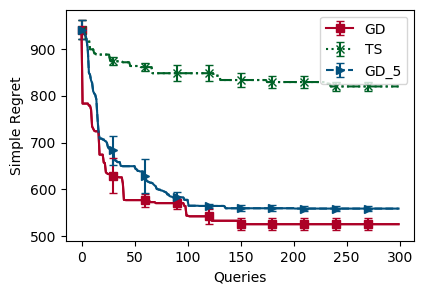

In [9]:
#mean=load_obj(func_name+'_Mean_'+'noisy_'+'Regret')
#error=load_obj(func_name+'_Error_'+'noisy_'+'Regret')
mean=load_obj(func_name+'_Mean_'+'Regret')
error=load_obj(func_name+'_Error_'+'Regret')
save_plot_T(mean,error)
